In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
base_shape_size = 8192
ws = 255
ol = 128
input_shape = (128, 64, 1)

In [16]:
from utils import calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from sound import Sound
from data_generators import NoisyTargetGenerator
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)

from tensorflow.keras.optimizers import Adam, AdamW

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
from IPython import display
import librosa

In [4]:
# print('Número de dispositivos: {}'.format(strategy.num_replicas_in_sync))

In [5]:
sound_base_train = Sound('/tf/Dados/Vozes/train/', '/tf/Dados/Ruido/train/', base_shape_size)
sound_base_val = Sound('/tf/Dados/Vozes/val/', '/tf/Dados/Ruido/val/', base_shape_size)

Loading Noise Files: 100%|██████████| 1627/1627 [00:02<00:00, 699.72it/s]


In [6]:
data_generator_train = NoisyTargetGenerator(sound_base_train.clean_sounds, sound_base_train.noise_sounds)
data_generator_val = NoisyTargetGenerator(sound_base_val.clean_sounds, sound_base_val.noise_sounds)

In [7]:
def generate_images(model, test_input, tar):
    
    prediction = model(test_input.reshape(-1, 128, 64, 1), training=True)
    plt.figure(figsize=(22, 7))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Log Power Spectrum - Som ruidoso', 'Log Power Spectrum - Som original', 'Log Power Spectrum - Som filtrado']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(10 * np.log10((display_list[i][..., 0])**2), aspect='auto', cmap='inferno')
        plt.colorbar(format='%+2.0f dB')  # Removi a variável 'im' e 'axs[0]'
        plt.axis('off')
    
    plt.show()

## Estrutura do modelo para 3 canais

![Descrição da imagem](model_structure.png)

In [8]:
class GenerateImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        indice_aleatorio = np.random.choice(self.x_val.shape[0])
        amostra_noisy_module = self.x_val[indice_aleatorio][np.newaxis, ...]
        amostra_original_module = self.y_val[indice_aleatorio][np.newaxis, ...]
        generate_images(self.model, amostra_noisy_module, amostra_original_module)

In [9]:
# Gera um novo lote de validação para cada época
validation_batch = next(data_generator_val.generate_sample_completo(batch_size=32))
x_val, y_val = validation_batch

In [10]:
steps_per_epoch_train = len(sound_base_train.clean_sounds)
steps_per_epoch_validation = len(sound_base_val.clean_sounds)

In [11]:
best_models_path = "/tf/Etapa 3/Artigos/PRIDNet/model_checkpoints/"
callbacks_lst = [
                 tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"original_best_PRIDNet_blindnoise_128x64.h5", save_freq=100, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10),
    GenerateImagesCallback(x_val, y_val)
]

In [12]:
def weighted_msle(y_true, y_pred):
    # Define o peso para penalizar mais as subestimações
    w = 2.0

    # Evita valores negativos adicionando 1 antes de aplicar o log
    log_true = 20 * tf.math.log(y_true + 1)
    log_pred = 20 * tf.math.log(y_pred + 1)

    # Cálculo do erro
    error = log_true - log_pred

    # Aplica pesos diferentes para superestimação e subestimação
    weighted_error = tf.where(error > 0, w * error, error)

    # Retorna a média do erro logarítmico quadrado ponderado
    return tf.reduce_mean(tf.abs(weighted_error))

In [18]:
# Configuração para uso de múltiplas GPUs
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [19]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [17]:
# model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0001))
# model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0009))
# Criar e compilar o modelo dentro do escopo da estratégia
from artigos.PRIDNet import create_model
# with strategy.scope():
#from artigos.PRIDNet import *
# with tf.device('/GPU:0'):
model = create_model(input_shape)
model.compile(
    loss='mse',
    optimizer=AdamW(
        learning_rate=1e-04,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
    )
)
# model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer=Adam())

Input = (None, 128, 64, 1)
Conv block = (None, 128, 64, 64)
Channel Attention = (None, 128, 64, 64)
Channel Attention Last CNN = (None, 128, 64, 1)
First phase = (None, 128, 64, 2)

Multi-scale feature extraction = (None, 128, 64, 6)
Kernel Selection Module = (None, 128, 64, 1)


In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 128, 64, 1)]         0         []                            
                                                                                                  
 convolutional_block_1 (Con  (None, 128, 64, 64)          111424    ['input_layer[0][0]']         
 volutional_block)                                                                                
                                                                                                  
 channel_attention_1 (Chann  (None, 128, 64, 64)          322       ['convolutional_block_1[0][0]'
 el_attention)                                                      ]                             
                                                                                            

Epoch 1/200
3506/3506 [==============================] - ETA: 0s - loss: 0.9172

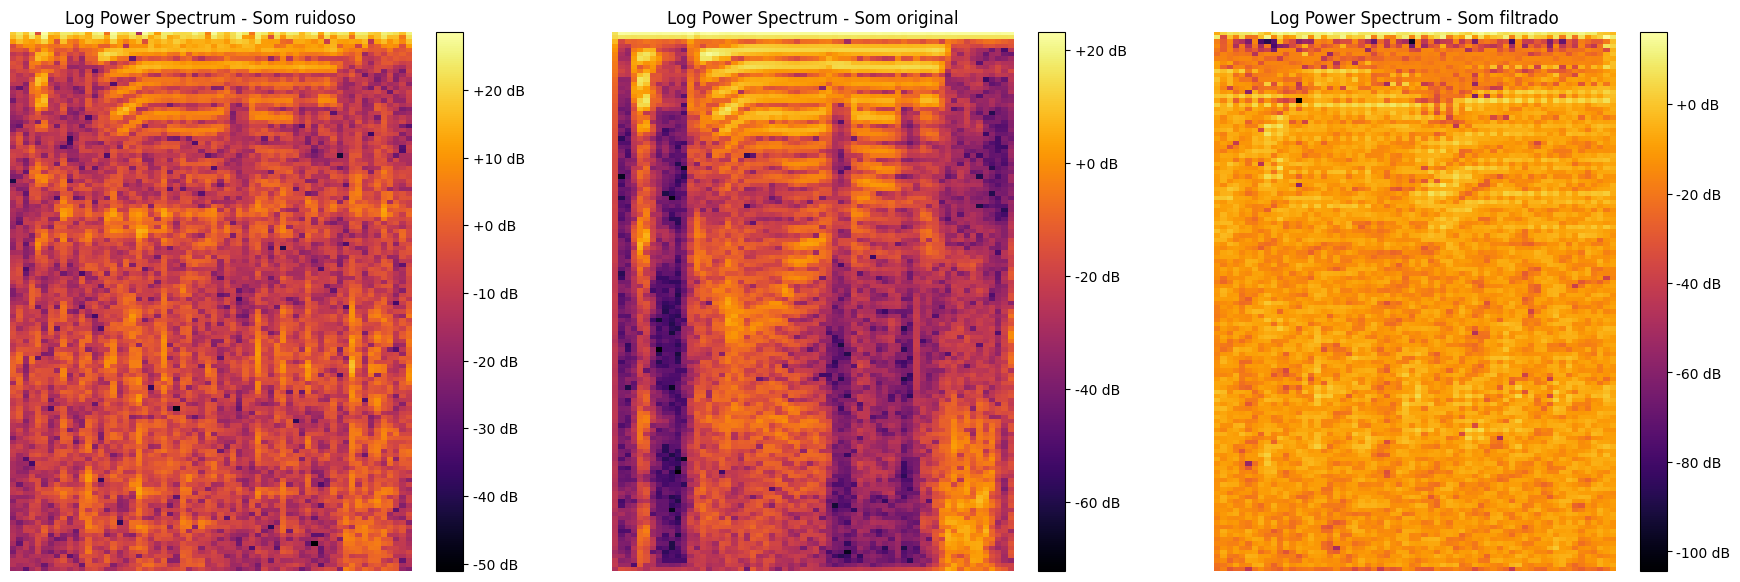

3506/3506 [==============================] - 1157s 324ms/step - loss: 0.9172 - val_loss: 0.1445 - lr: 1.0000e-04
Epoch 2/200
3506/3506 [==============================] - ETA: 0s - loss: 0.1038

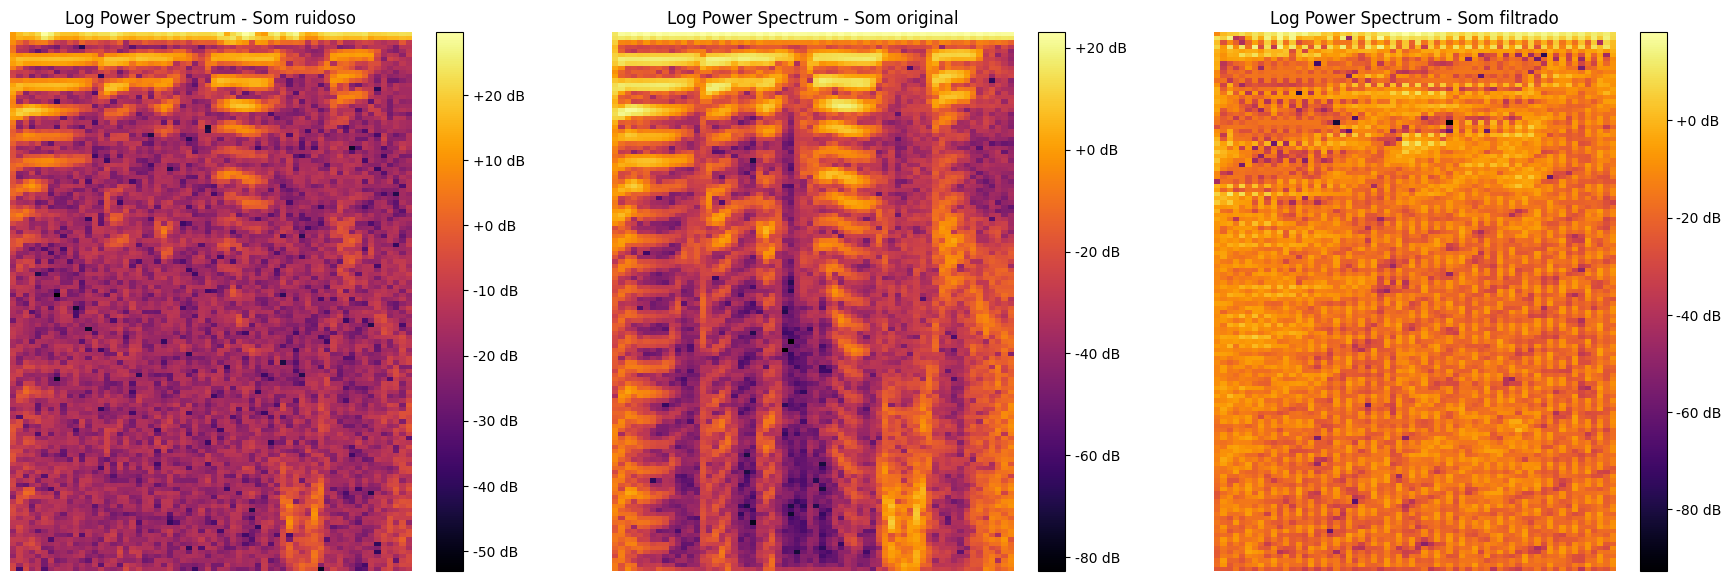

3506/3506 [==============================] - 1129s 322ms/step - loss: 0.1038 - val_loss: 0.1043 - lr: 1.0000e-04
Epoch 3/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0802

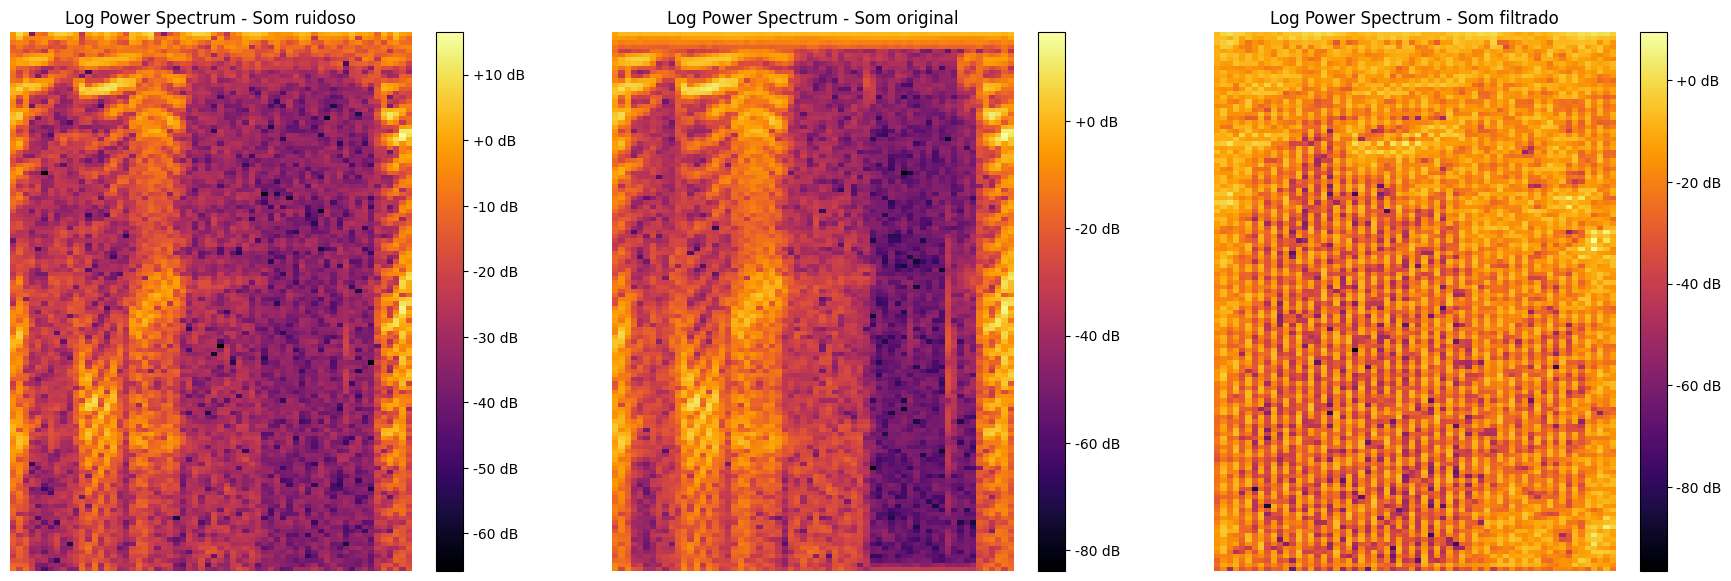

3506/3506 [==============================] - 1135s 324ms/step - loss: 0.0802 - val_loss: 0.0888 - lr: 1.0000e-04
Epoch 4/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0694

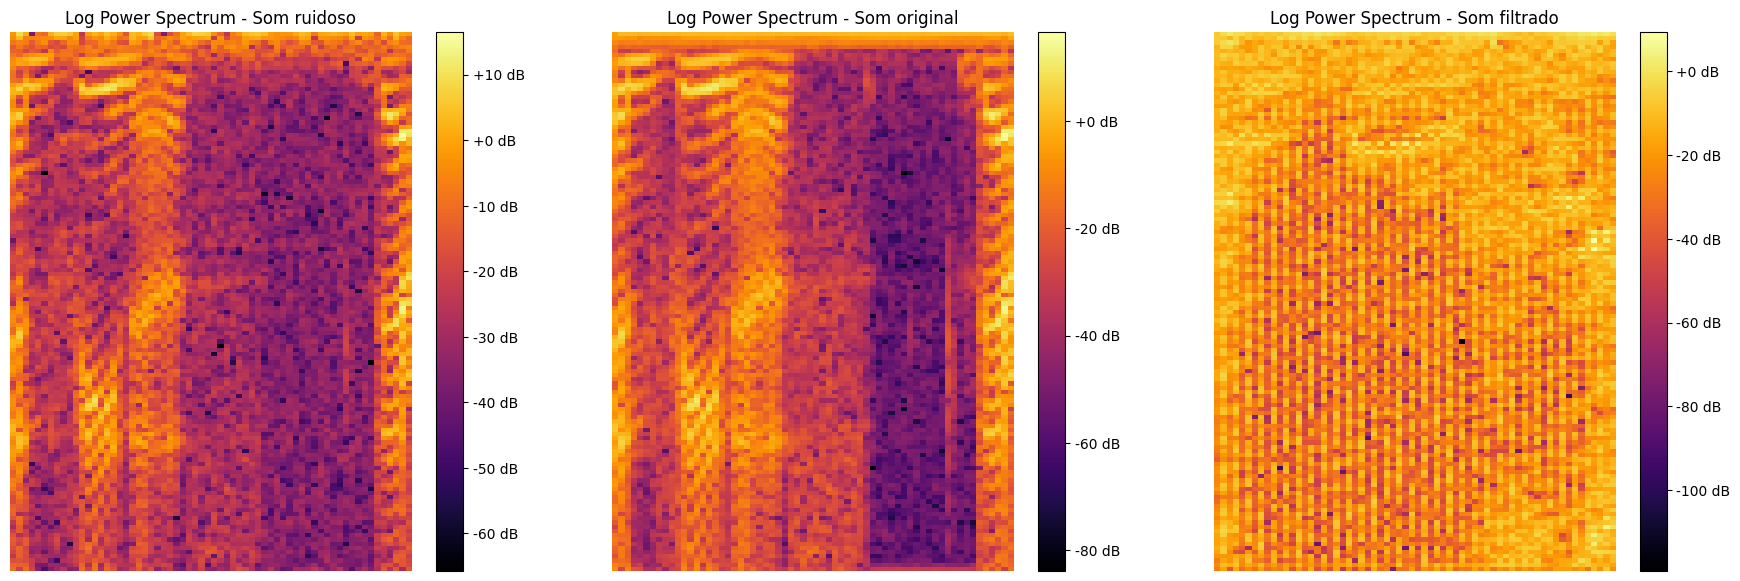

3506/3506 [==============================] - 1136s 324ms/step - loss: 0.0694 - val_loss: 0.0745 - lr: 1.0000e-04
Epoch 5/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0634

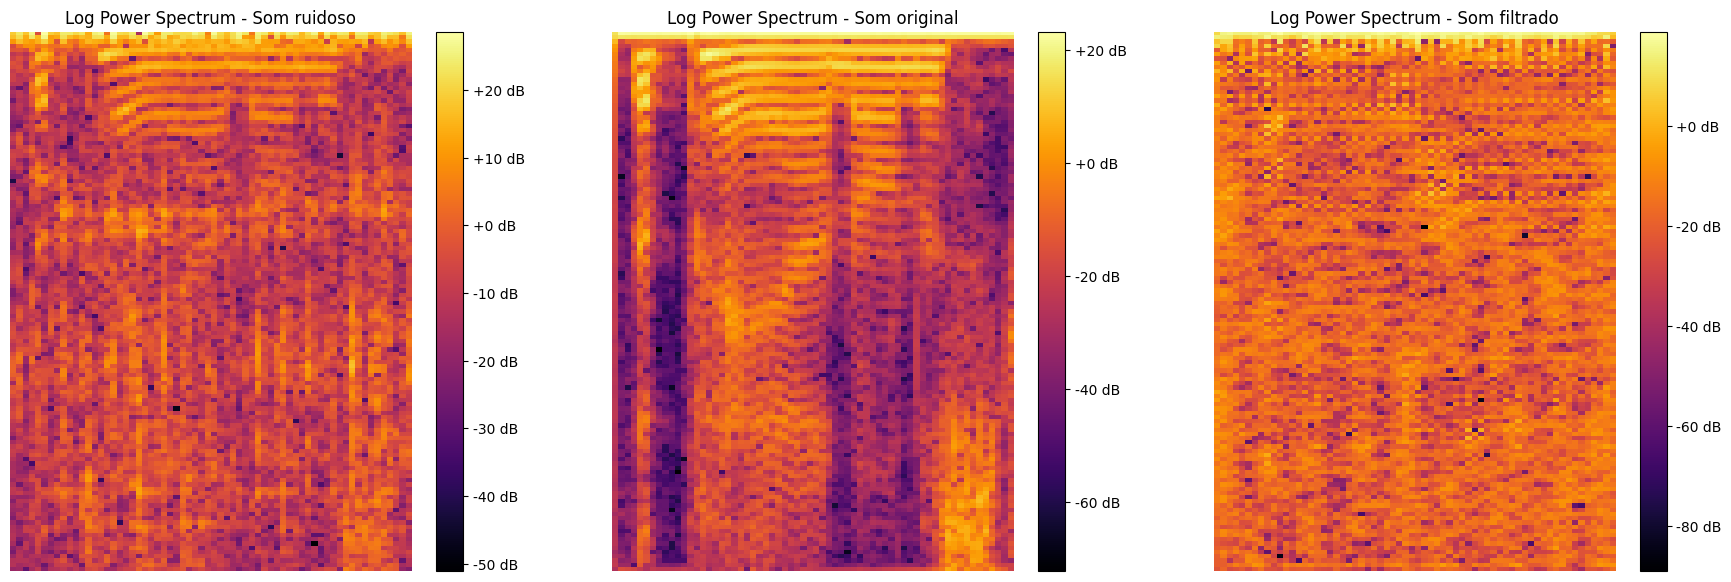

3506/3506 [==============================] - 1139s 325ms/step - loss: 0.0634 - val_loss: 0.0777 - lr: 1.0000e-04
Epoch 6/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0606

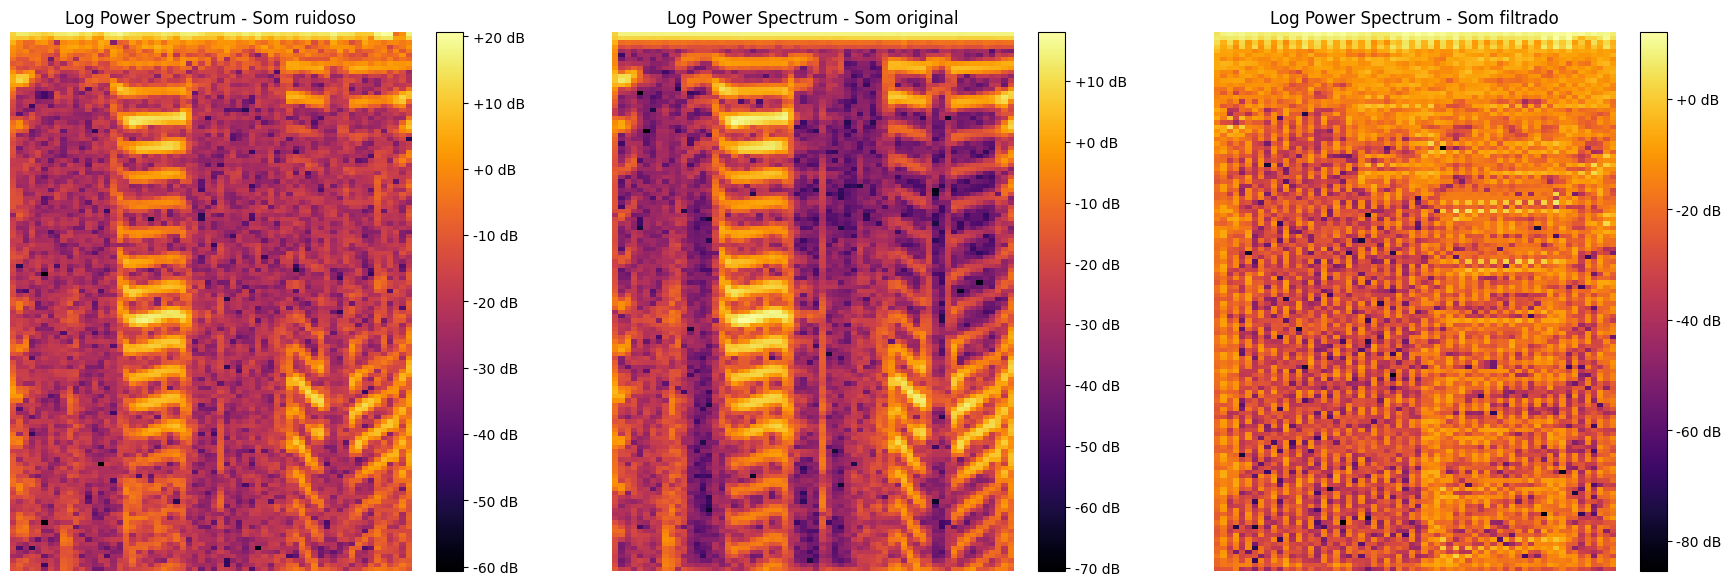

3506/3506 [==============================] - 1132s 323ms/step - loss: 0.0606 - val_loss: 0.0792 - lr: 1.0000e-04
Epoch 7/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0575

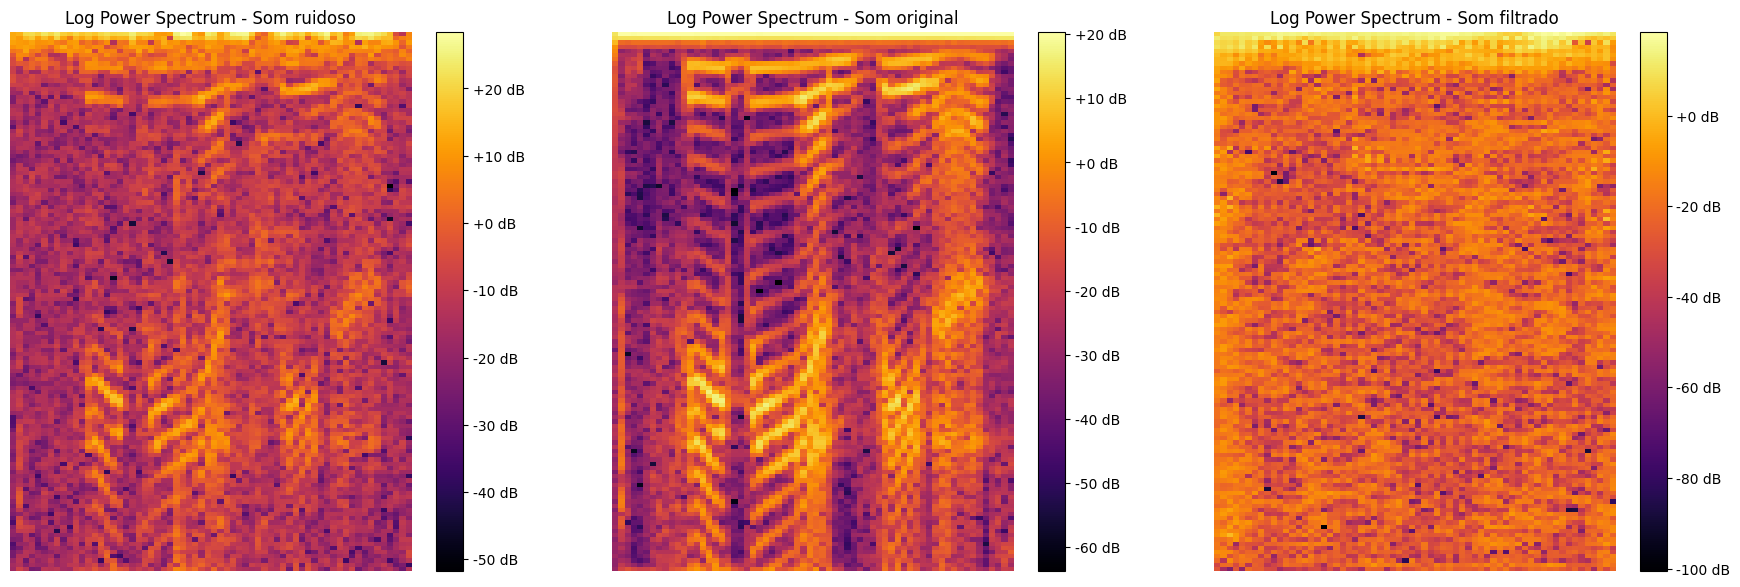

3506/3506 [==============================] - 1062s 303ms/step - loss: 0.0575 - val_loss: 0.0652 - lr: 1.0000e-04
Epoch 8/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0550

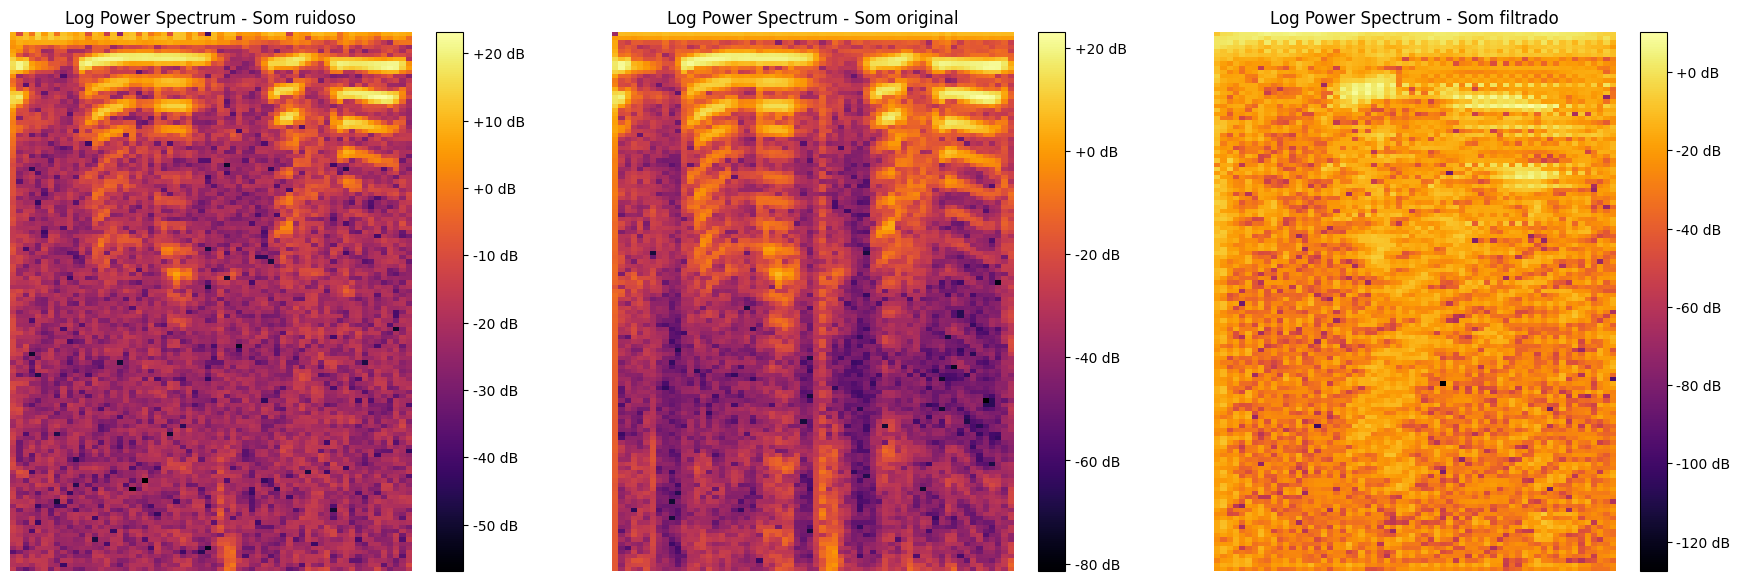

3506/3506 [==============================] - 1043s 297ms/step - loss: 0.0550 - val_loss: 0.0678 - lr: 1.0000e-04
Epoch 9/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0522

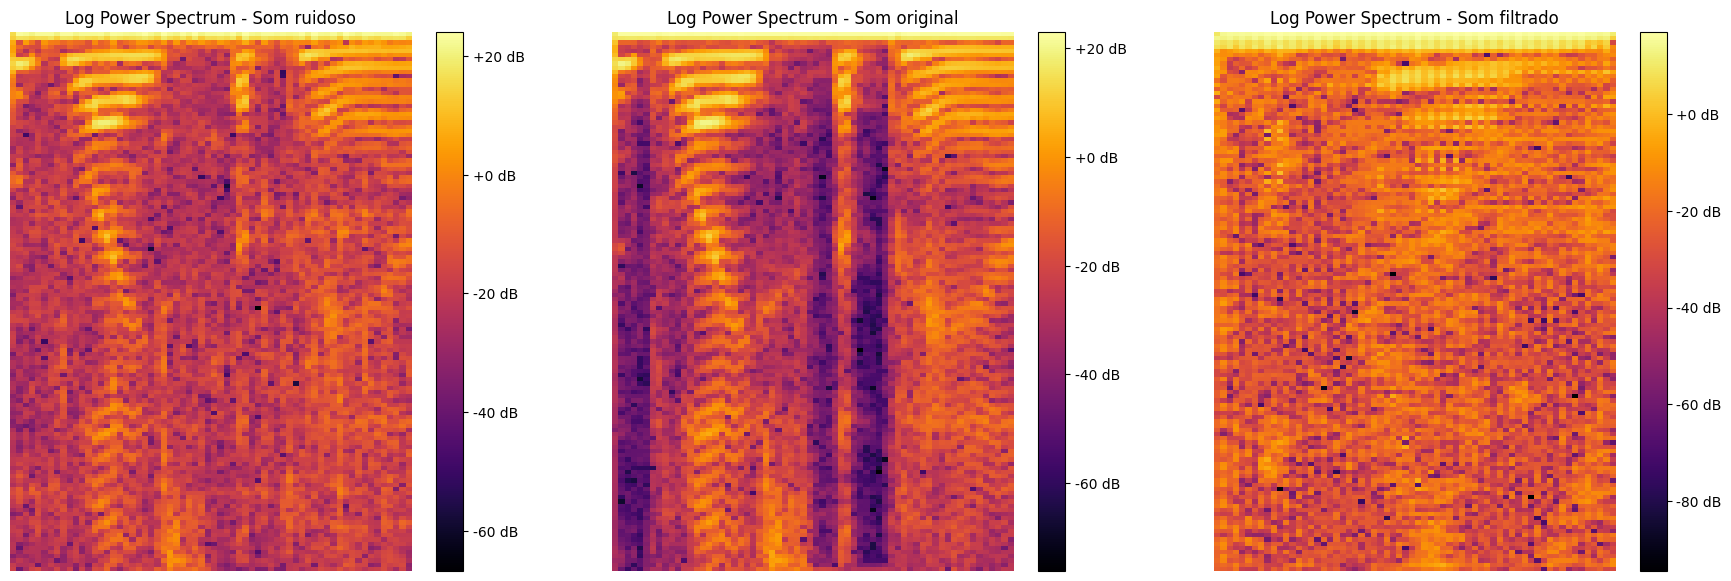

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0522 - val_loss: 0.0648 - lr: 1.0000e-04
Epoch 10/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0519

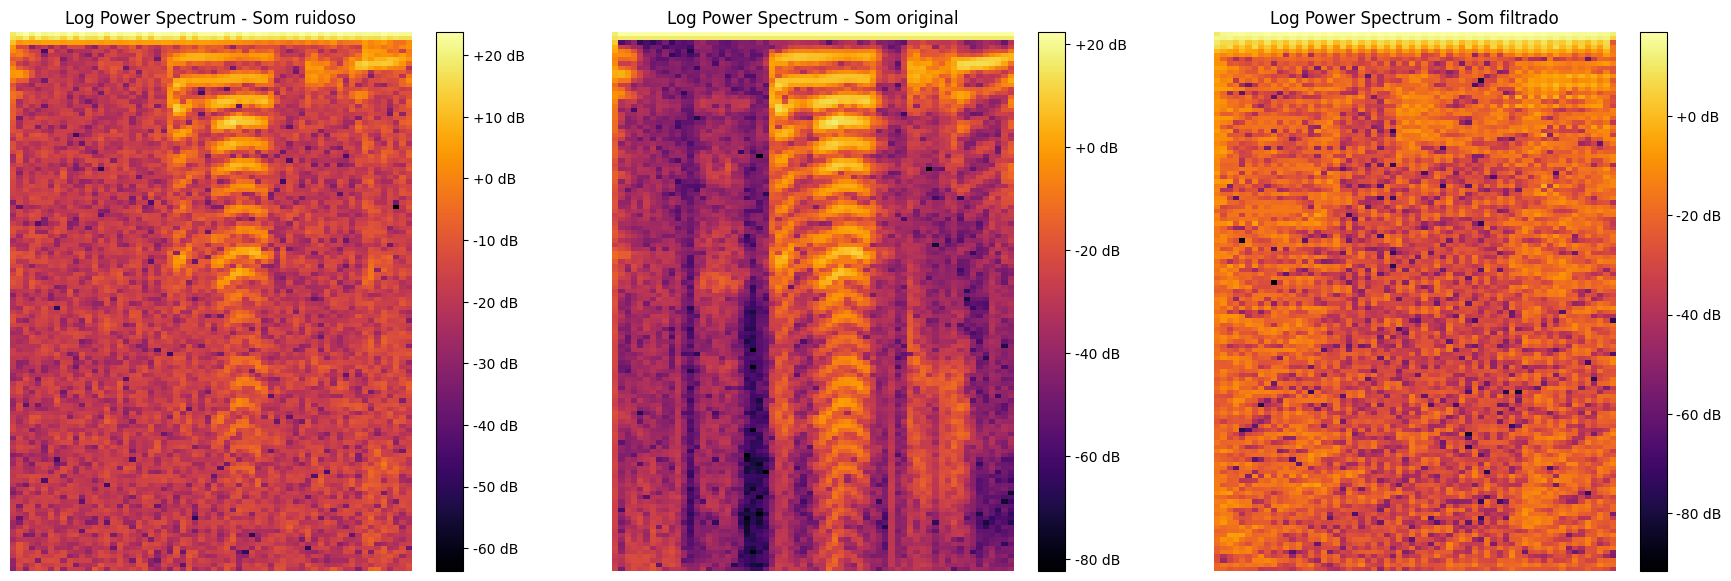

3506/3506 [==============================] - 1030s 294ms/step - loss: 0.0519 - val_loss: 0.0621 - lr: 1.0000e-04
Epoch 11/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0507

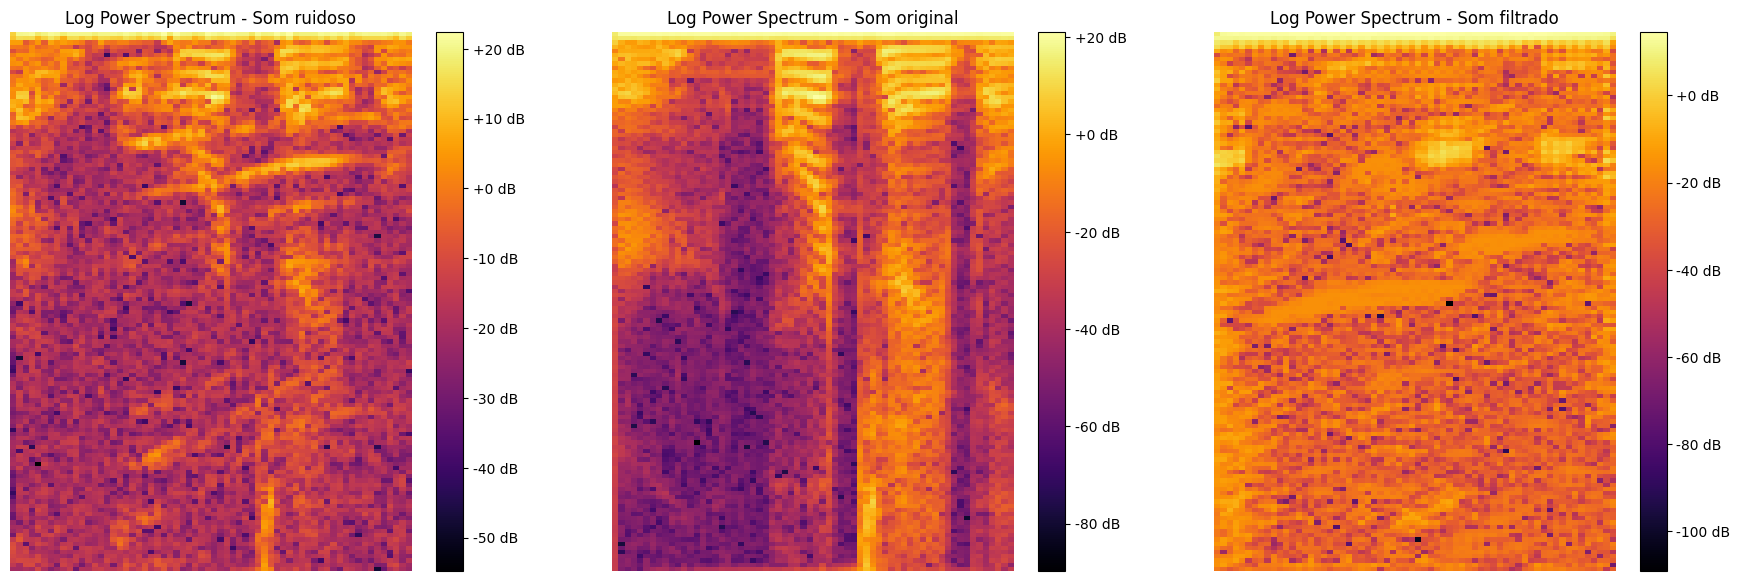

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0507 - val_loss: 0.0639 - lr: 1.0000e-04
Epoch 12/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0499

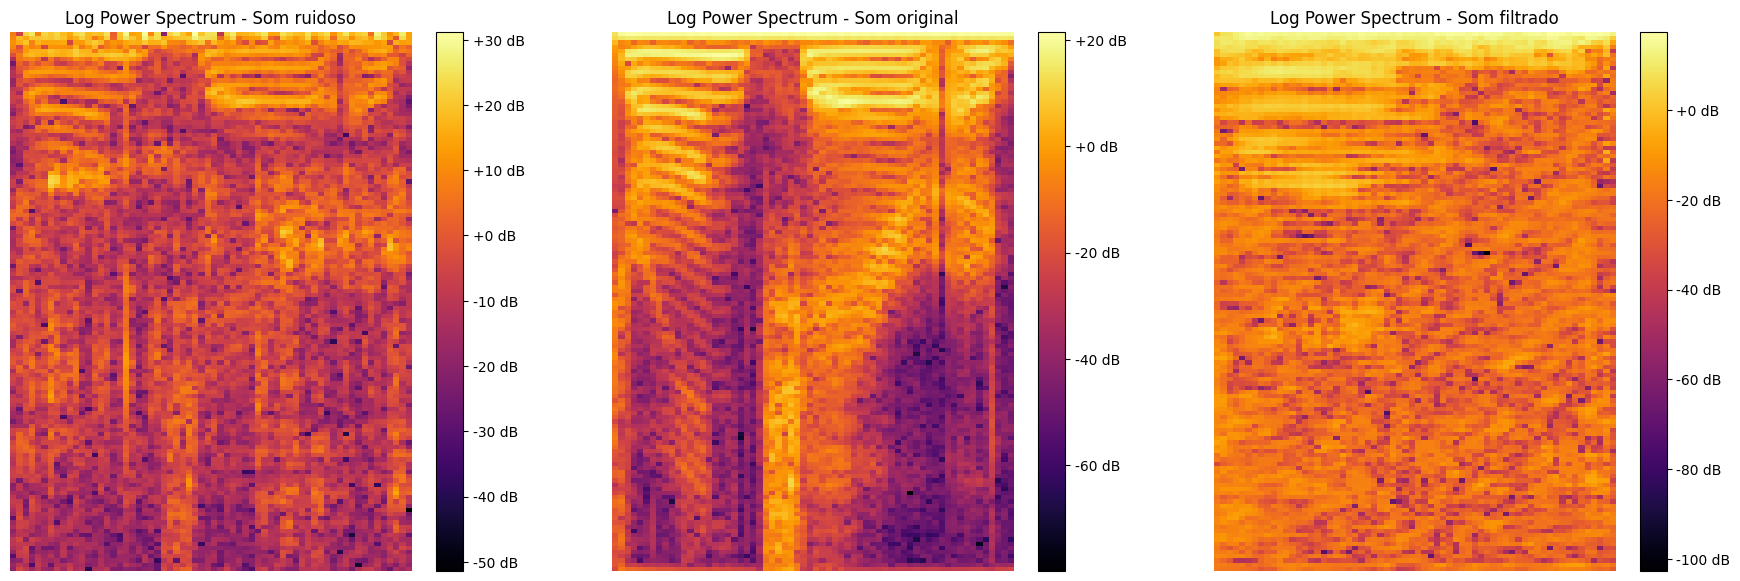

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0499 - val_loss: 0.0595 - lr: 1.0000e-04
Epoch 13/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0494

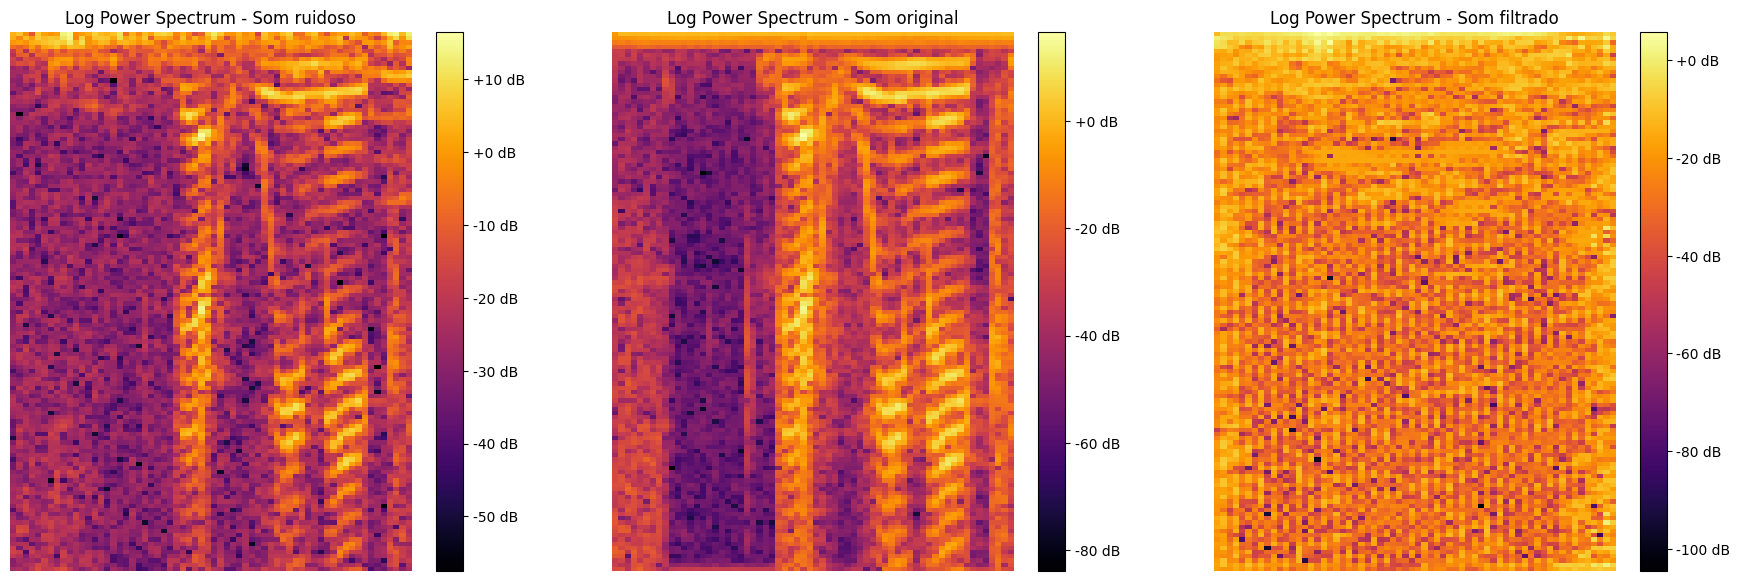

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0494 - val_loss: 0.0562 - lr: 1.0000e-04
Epoch 14/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0483

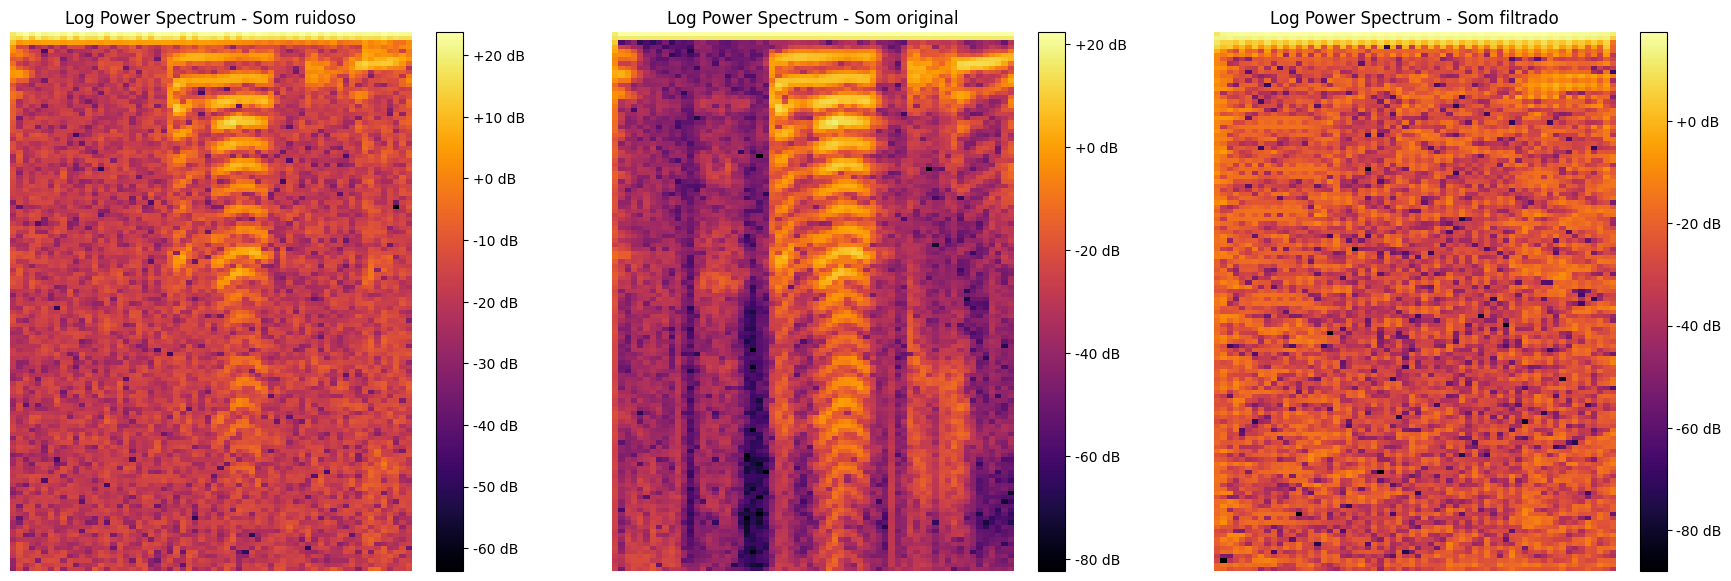

3506/3506 [==============================] - 1030s 294ms/step - loss: 0.0483 - val_loss: 0.0605 - lr: 1.0000e-04
Epoch 15/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0470

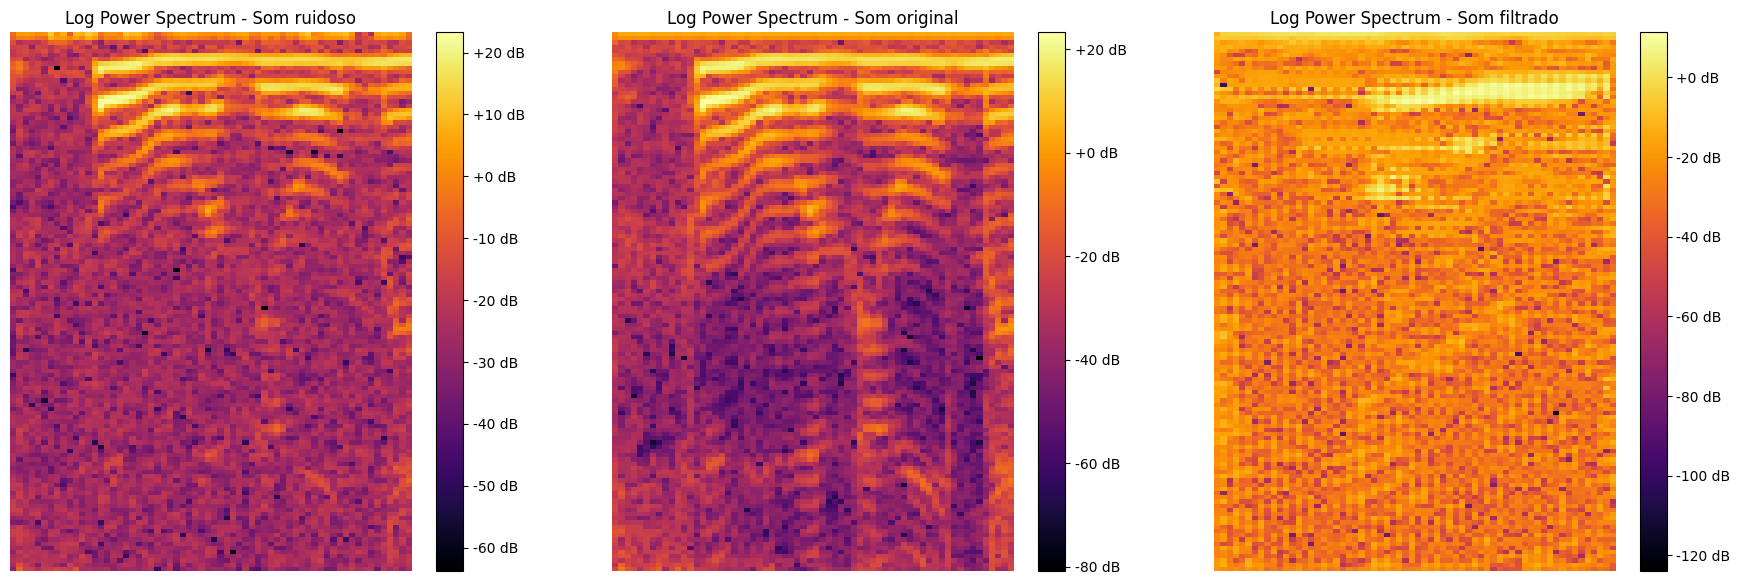

3506/3506 [==============================] - 1030s 294ms/step - loss: 0.0470 - val_loss: 0.0600 - lr: 1.0000e-04
Epoch 16/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0461

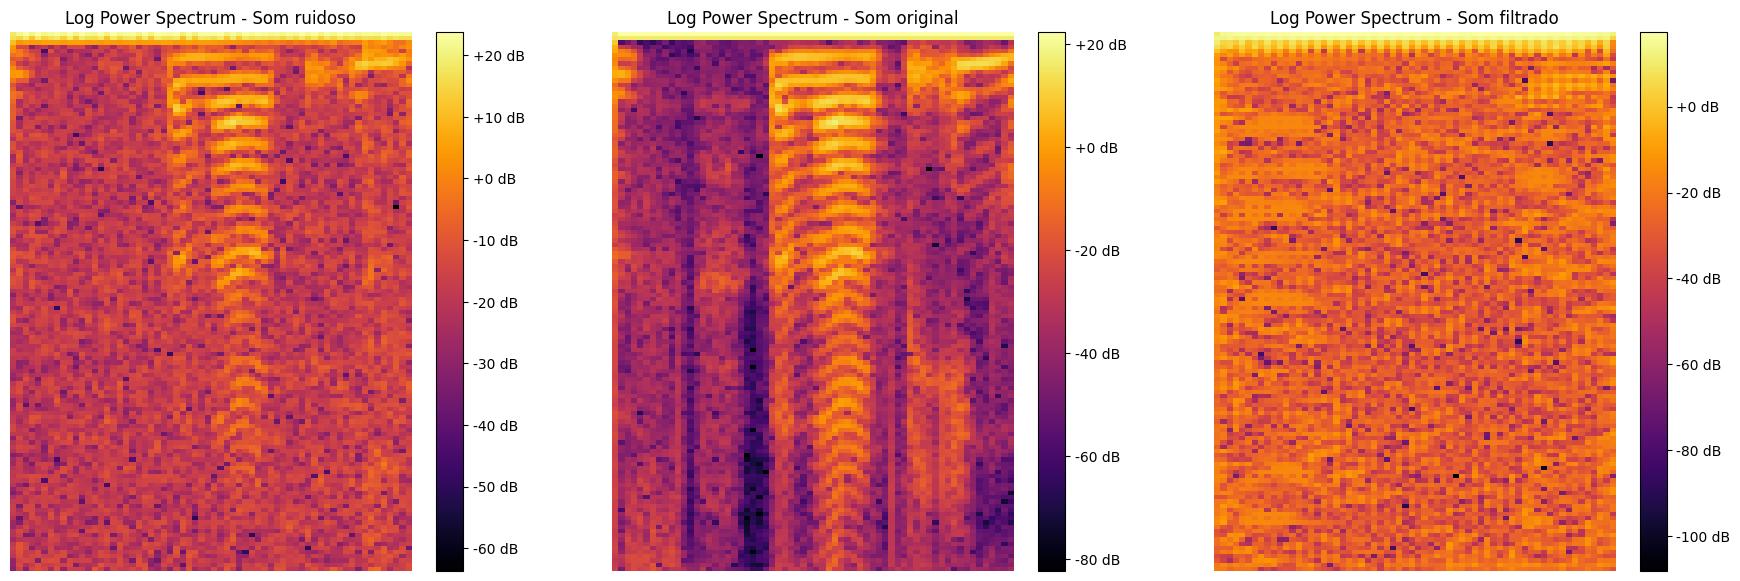

3506/3506 [==============================] - 1030s 294ms/step - loss: 0.0461 - val_loss: 0.0543 - lr: 1.0000e-04
Epoch 17/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0464

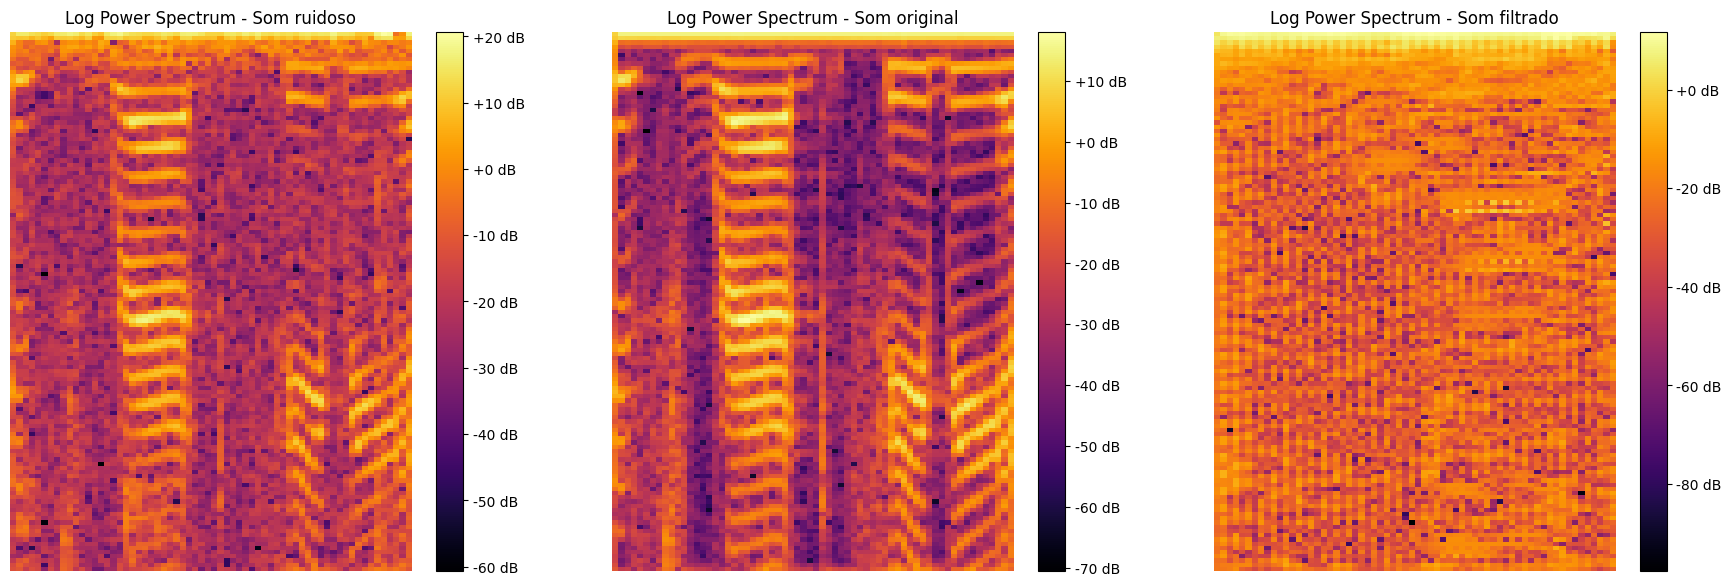

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0464 - val_loss: 0.0560 - lr: 1.0000e-04
Epoch 18/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0458

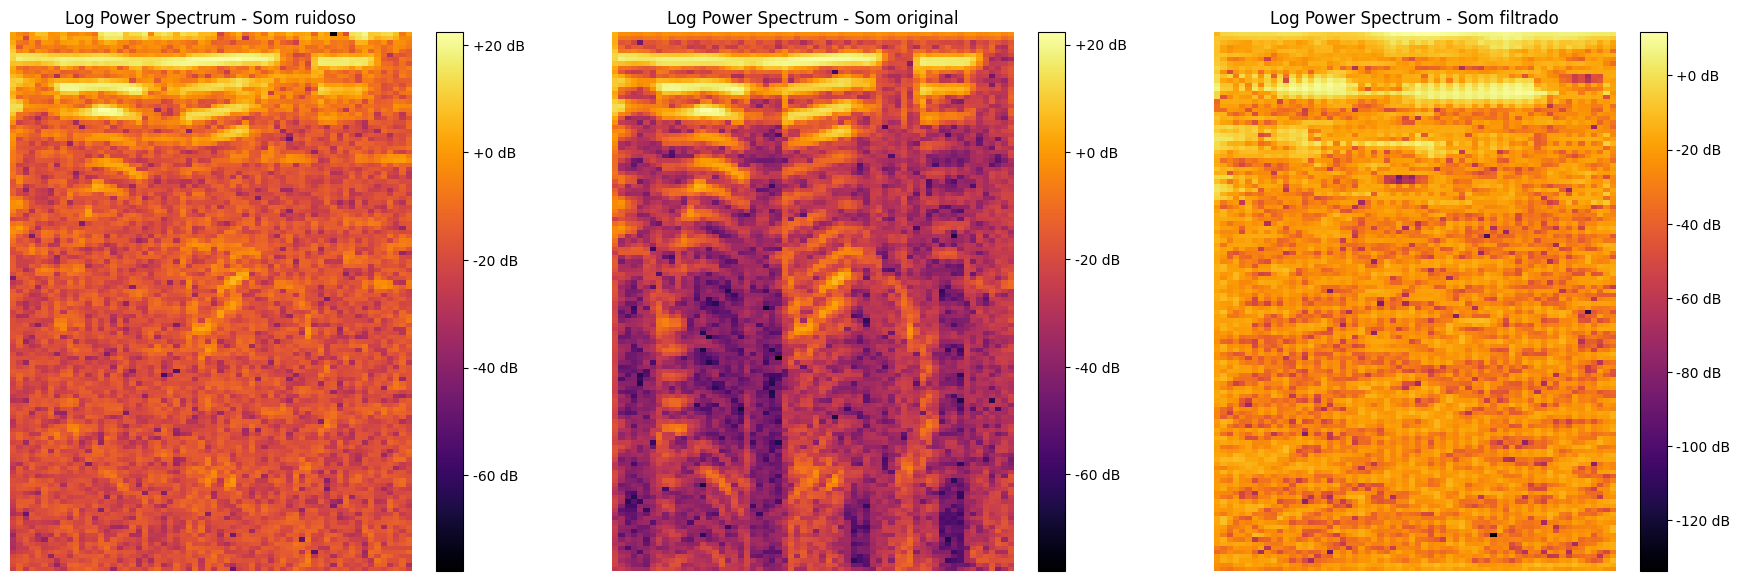

3506/3506 [==============================] - 1030s 294ms/step - loss: 0.0458 - val_loss: 0.0542 - lr: 1.0000e-04
Epoch 19/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0444
Epoch 19: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.


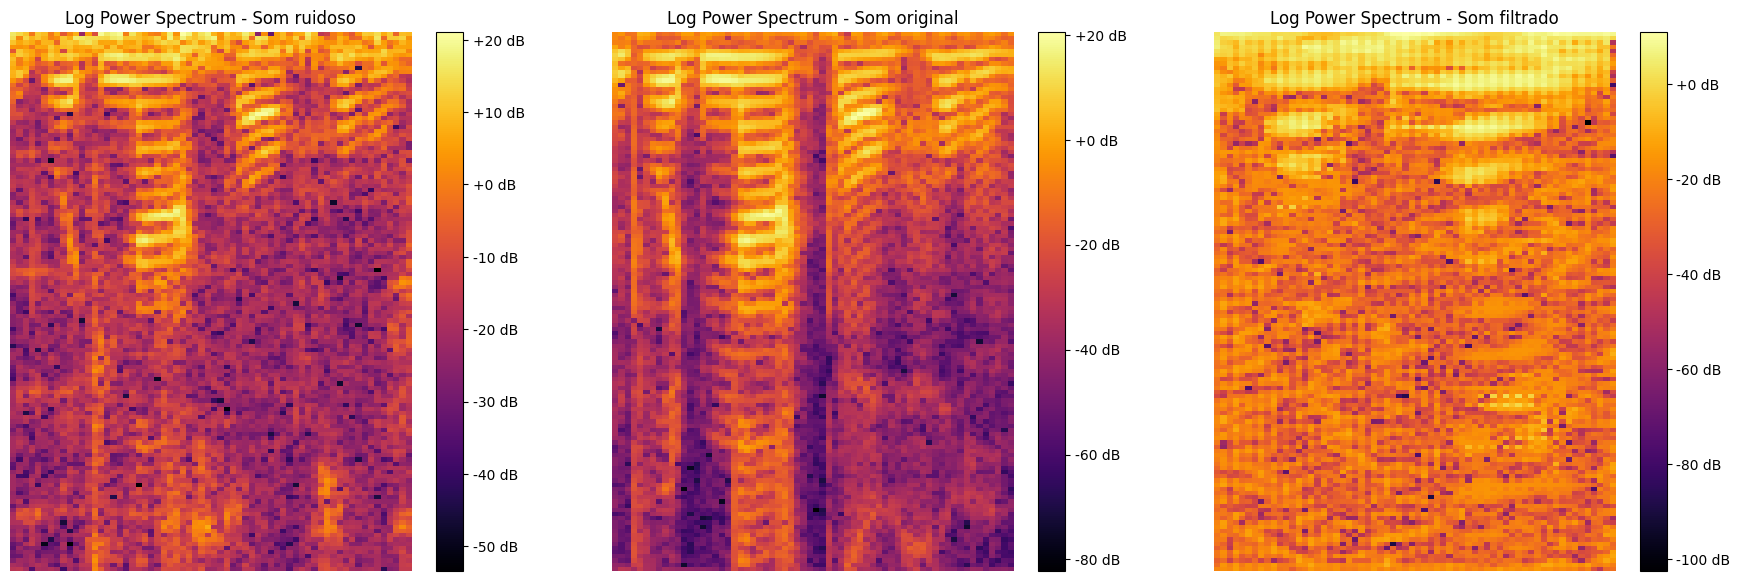

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0444 - val_loss: 0.0593 - lr: 1.0000e-04
Epoch 20/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0439

/tmp/ipykernel_18334/517927113.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10 * np.log10((display_list[i][..., 0])**2), aspect='auto', cmap='inferno')


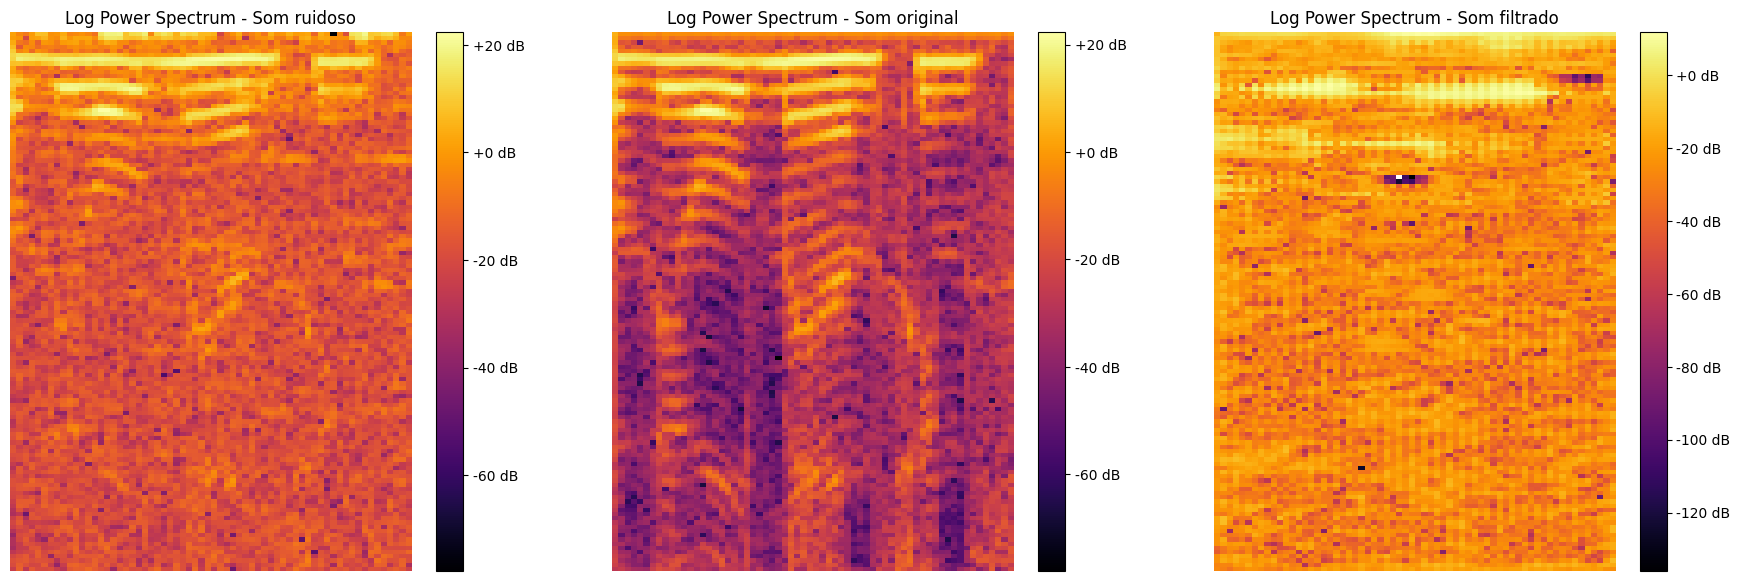

3506/3506 [==============================] - 1030s 294ms/step - loss: 0.0439 - val_loss: 0.0506 - lr: 7.0000e-05
Epoch 21/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0441

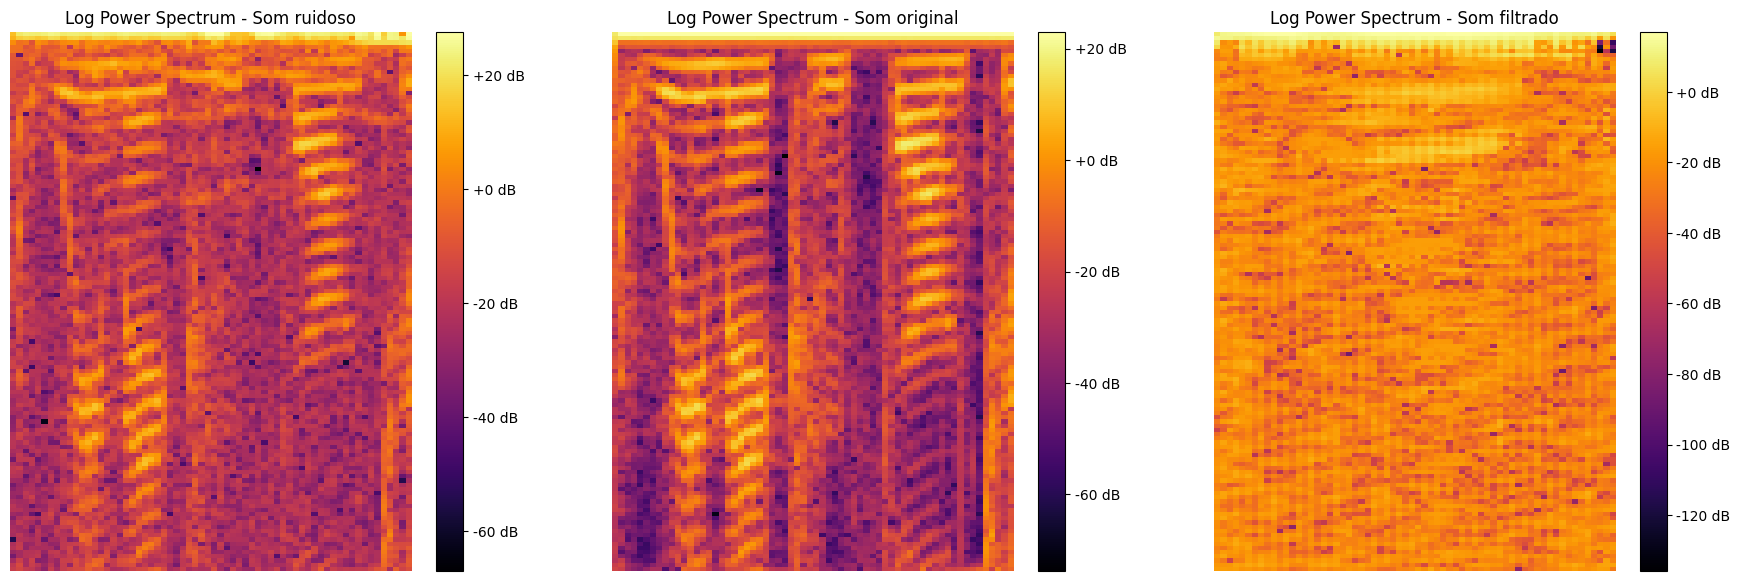

3506/3506 [==============================] - 1030s 294ms/step - loss: 0.0441 - val_loss: 0.0518 - lr: 7.0000e-05
Epoch 22/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0435

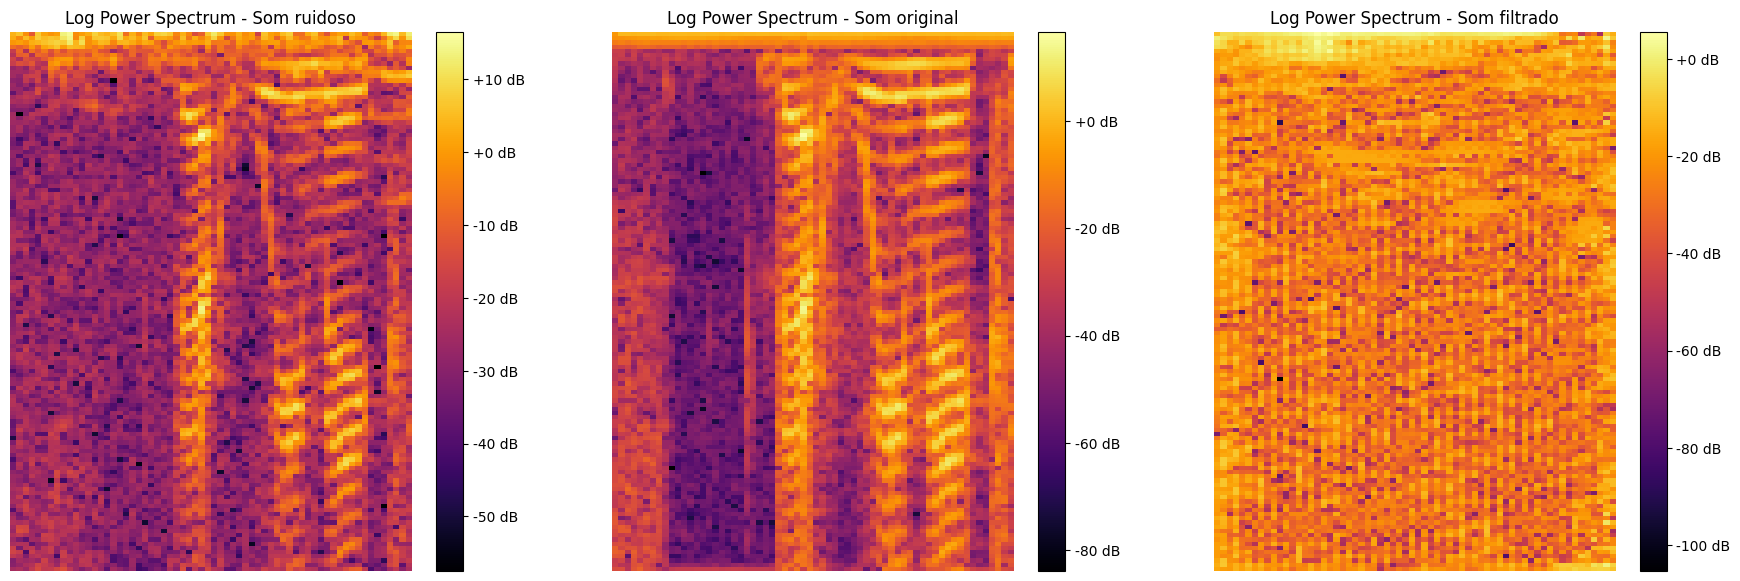

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0435 - val_loss: 0.0495 - lr: 7.0000e-05
Epoch 23/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0423

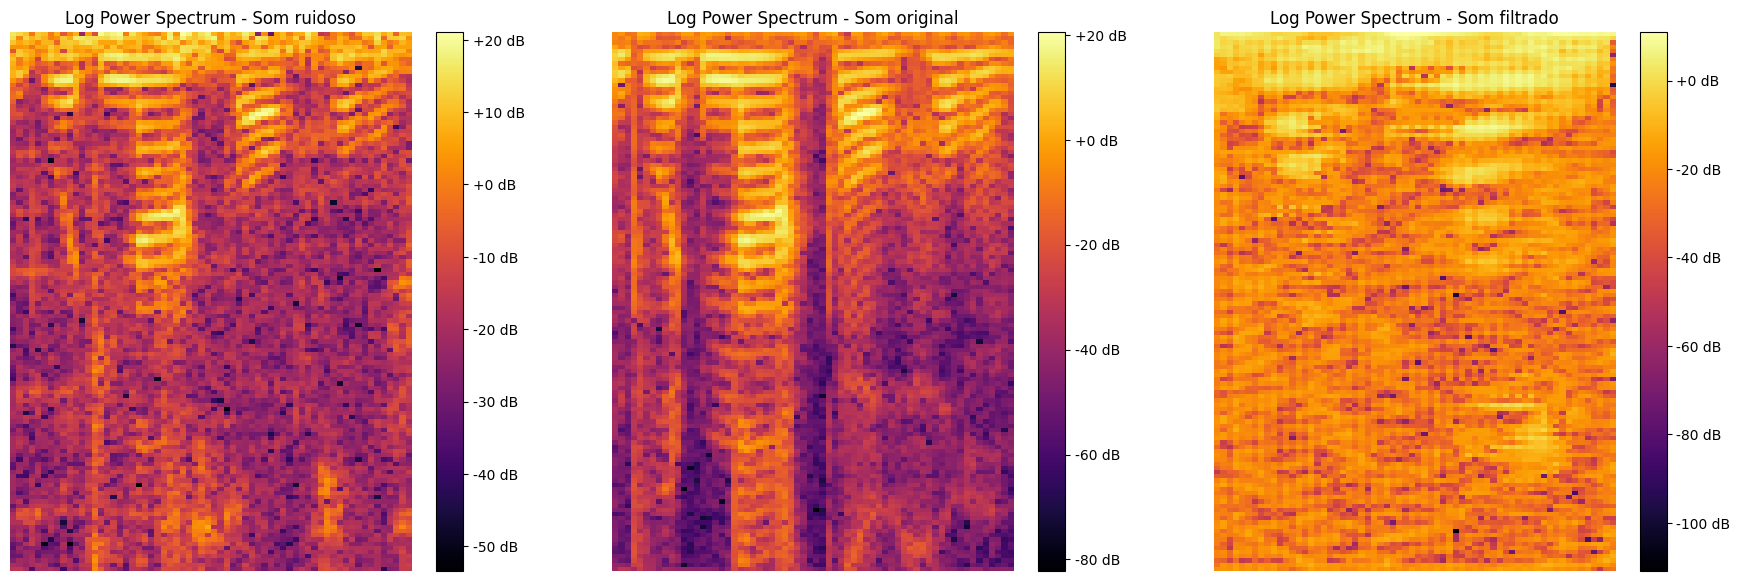

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0423 - val_loss: 0.0547 - lr: 7.0000e-05
Epoch 24/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0422

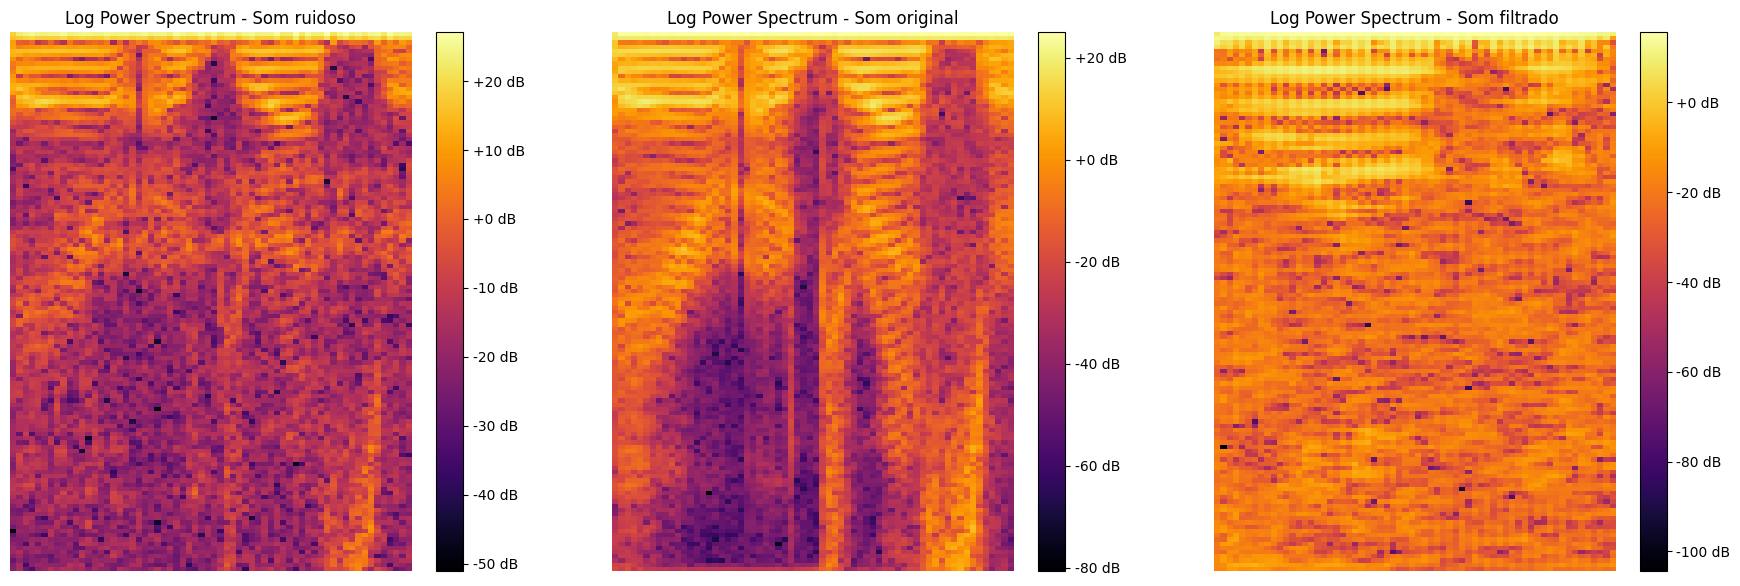

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0422 - val_loss: 0.0565 - lr: 7.0000e-05
Epoch 25/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0418
Epoch 25: ReduceLROnPlateau reducing learning rate to 4.899999621557071e-05.


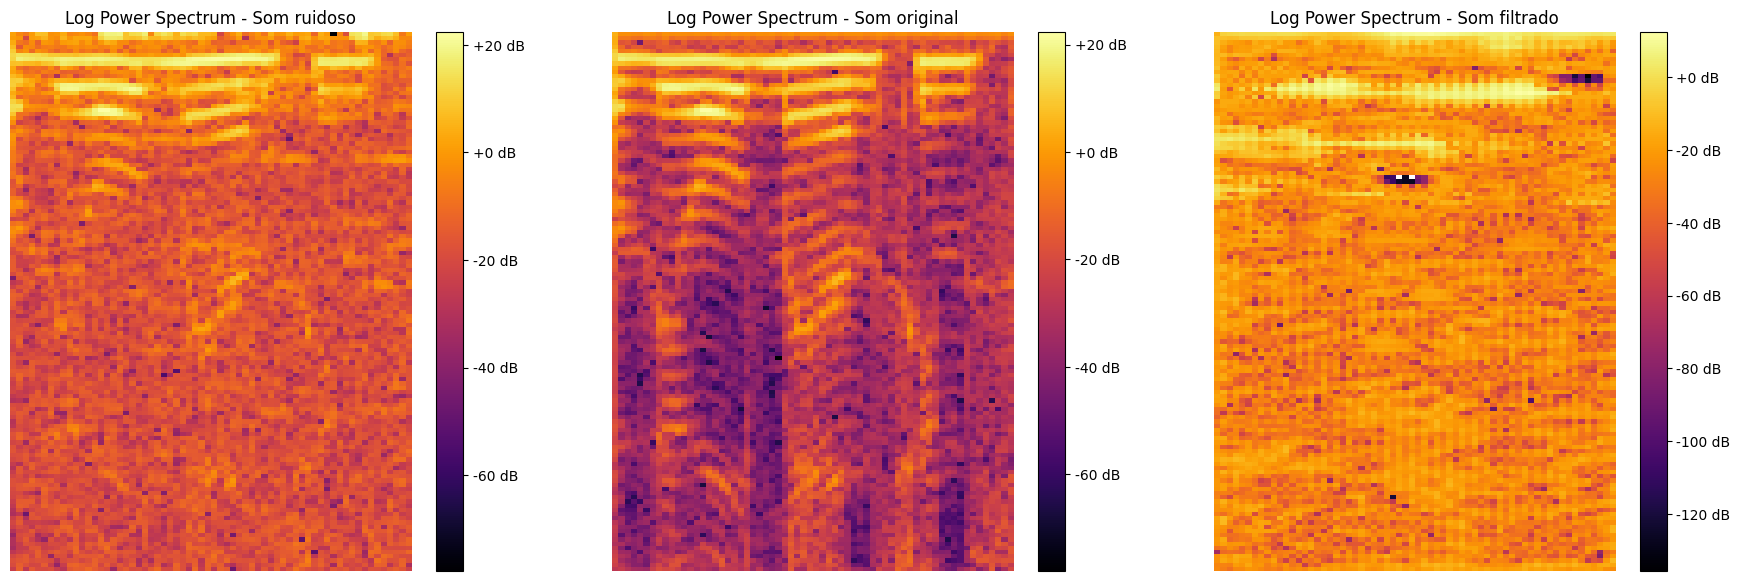

3506/3506 [==============================] - 1030s 294ms/step - loss: 0.0418 - val_loss: 0.0524 - lr: 7.0000e-05
Epoch 26/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0424

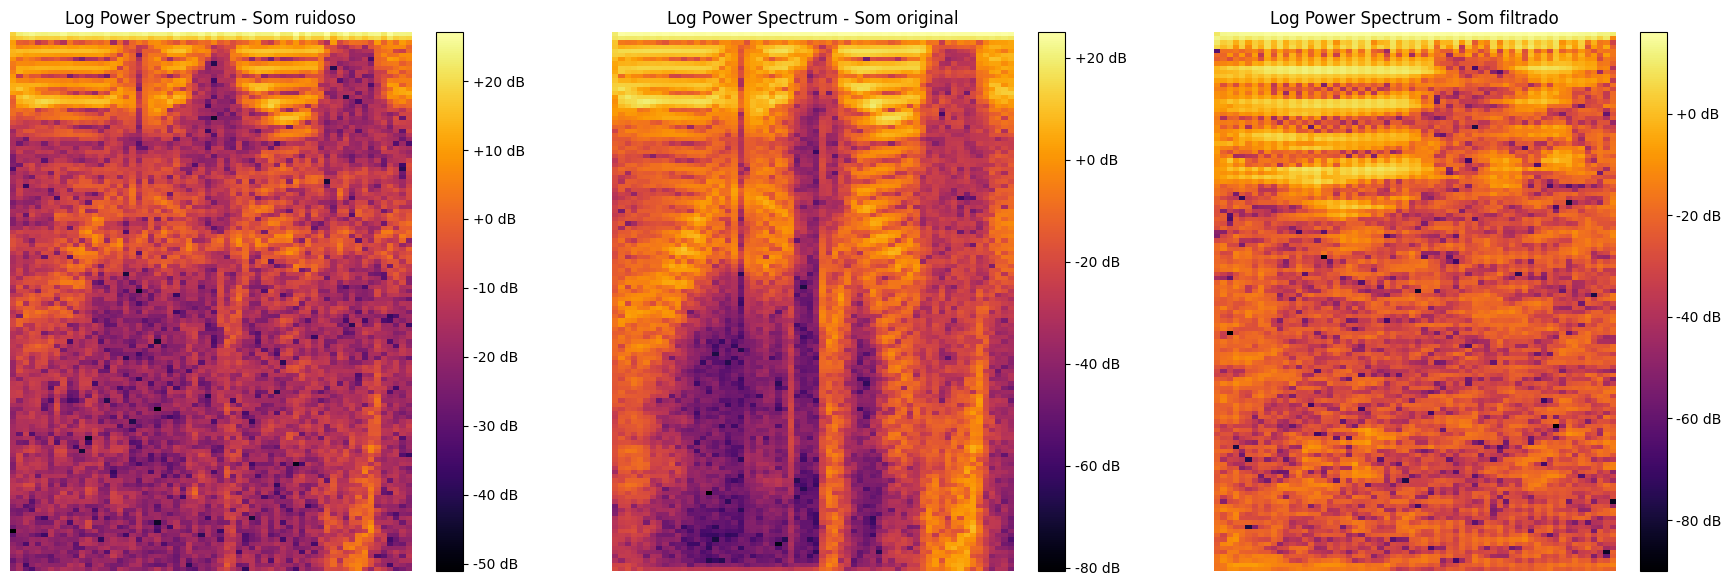

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0424 - val_loss: 0.0511 - lr: 4.9000e-05
Epoch 27/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0416

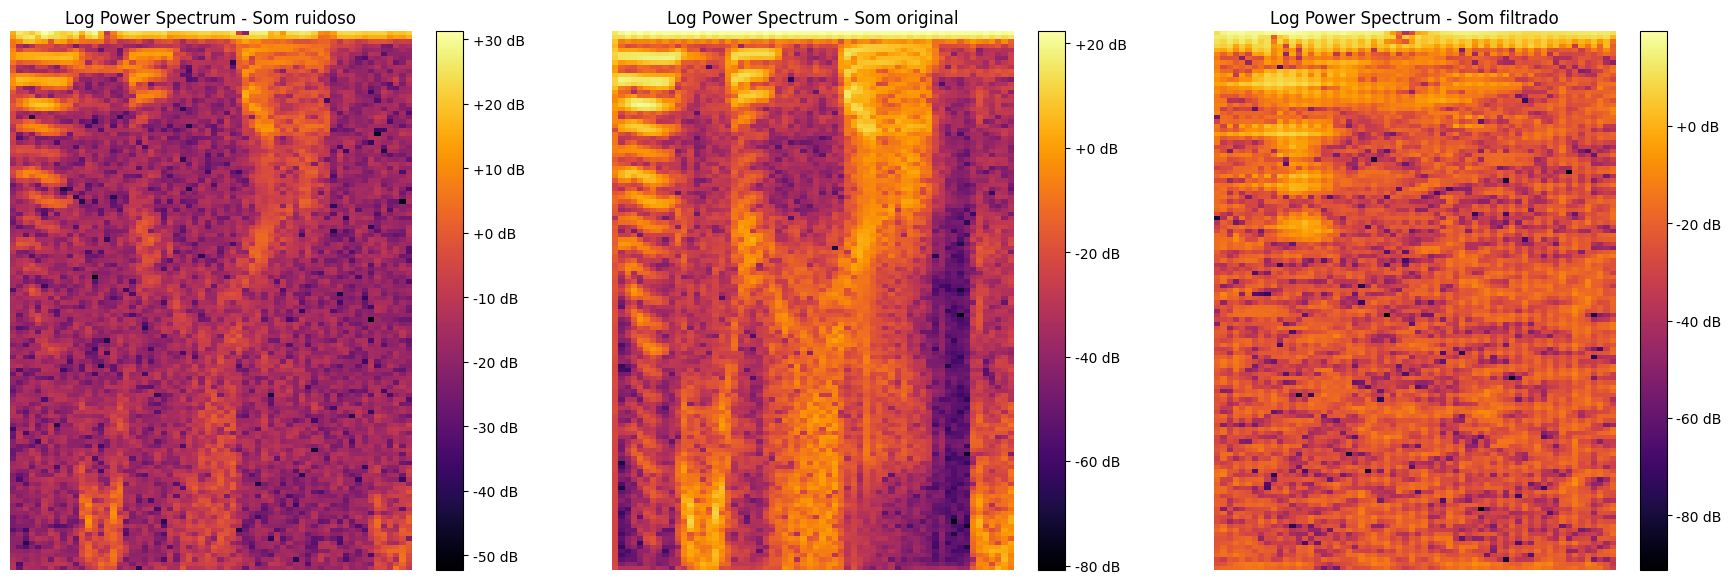

3506/3506 [==============================] - 1030s 294ms/step - loss: 0.0416 - val_loss: 0.0610 - lr: 4.9000e-05
Epoch 28/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0408
Epoch 28: ReduceLROnPlateau reducing learning rate to 3.4299996332265434e-05.


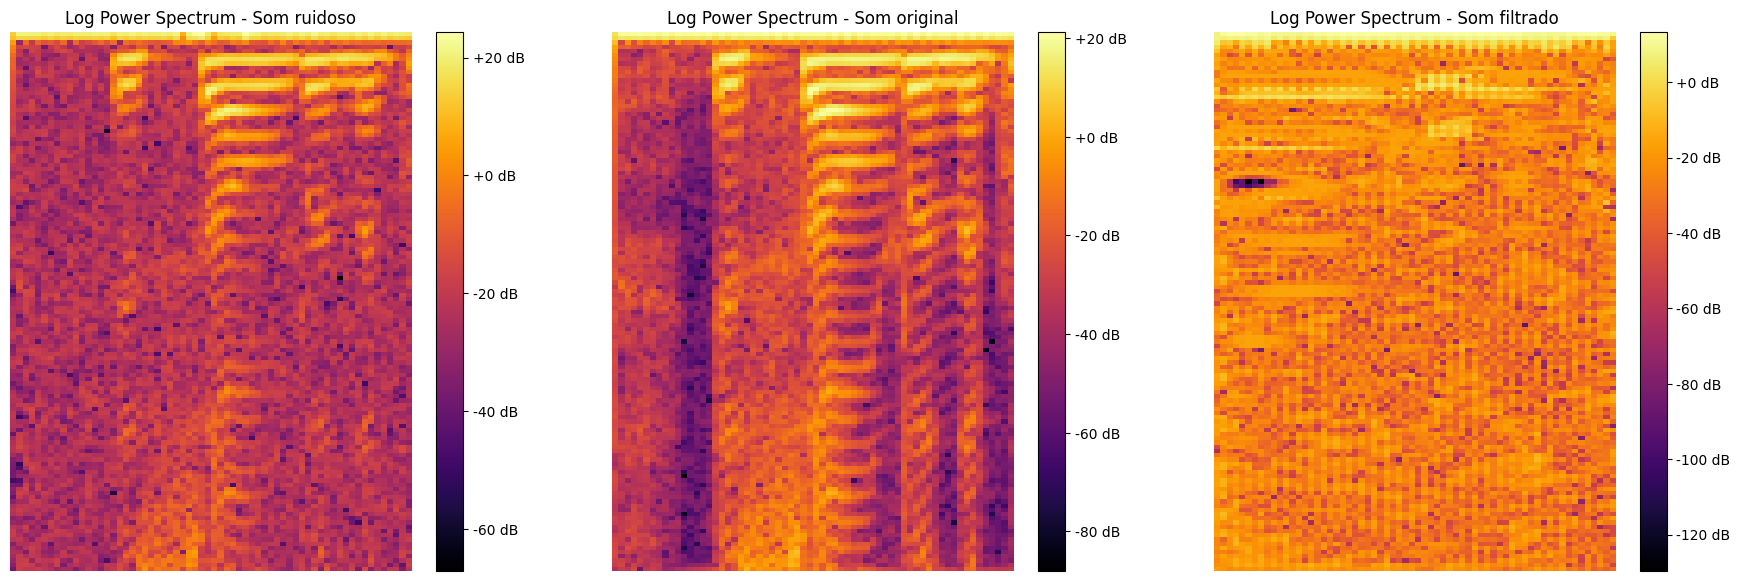

3506/3506 [==============================] - 1032s 294ms/step - loss: 0.0408 - val_loss: 0.0502 - lr: 4.9000e-05
Epoch 29/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0408

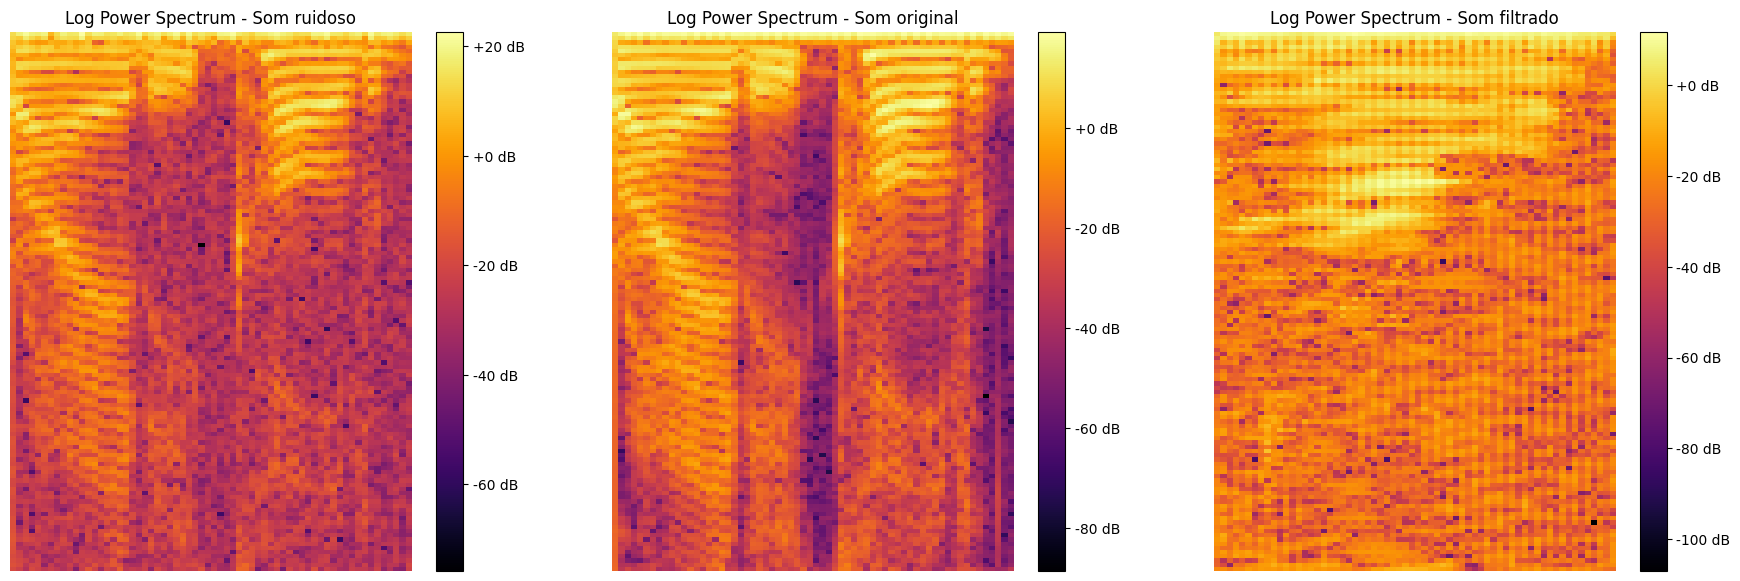

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0408 - val_loss: 0.0540 - lr: 3.4300e-05
Epoch 30/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0406

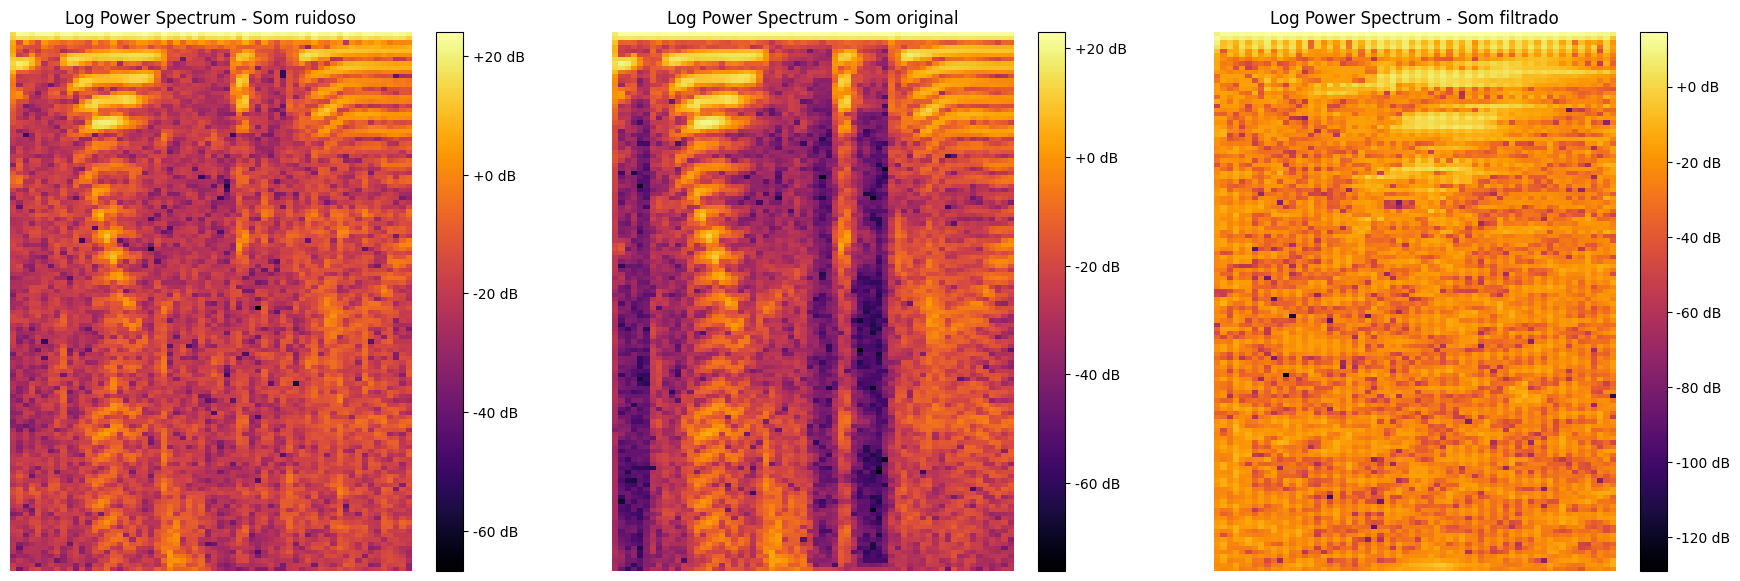

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0406 - val_loss: 0.0563 - lr: 3.4300e-05
Epoch 31/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0405

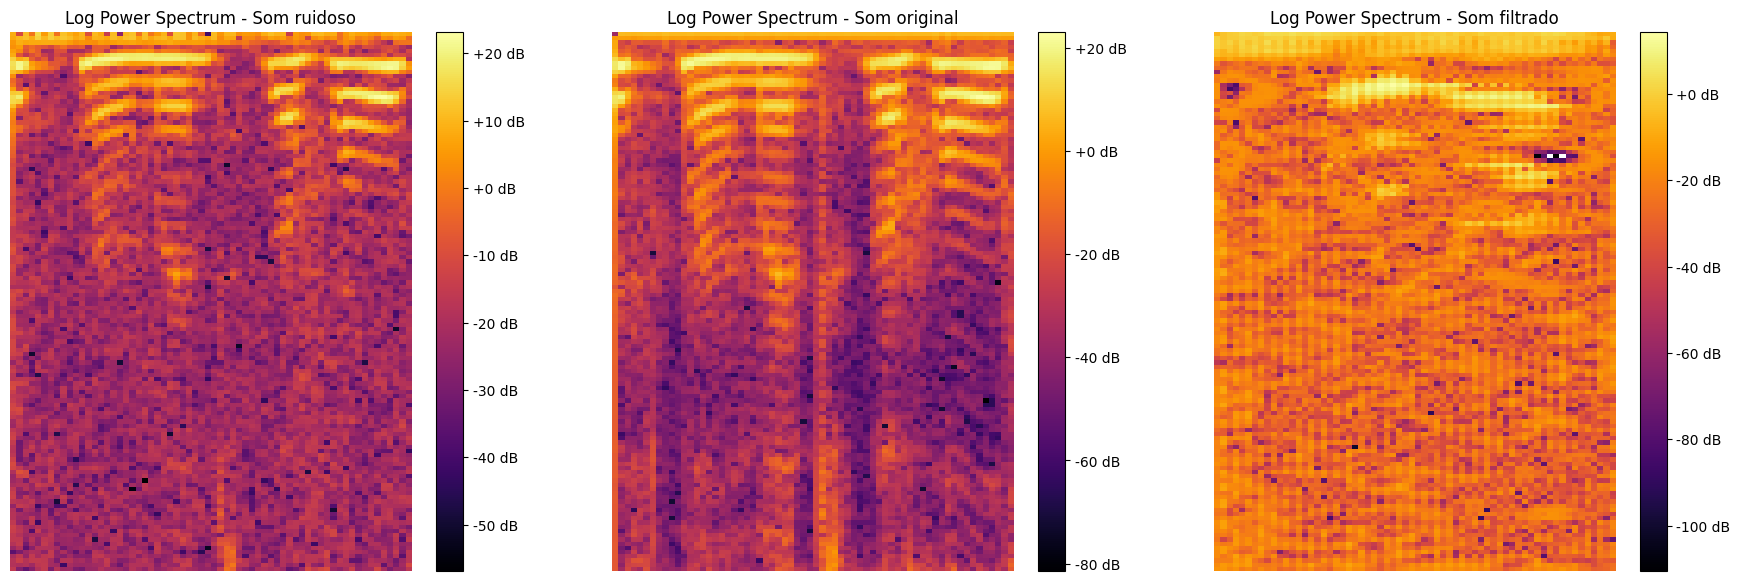

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0405 - val_loss: 0.0494 - lr: 3.4300e-05
Epoch 32/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0401

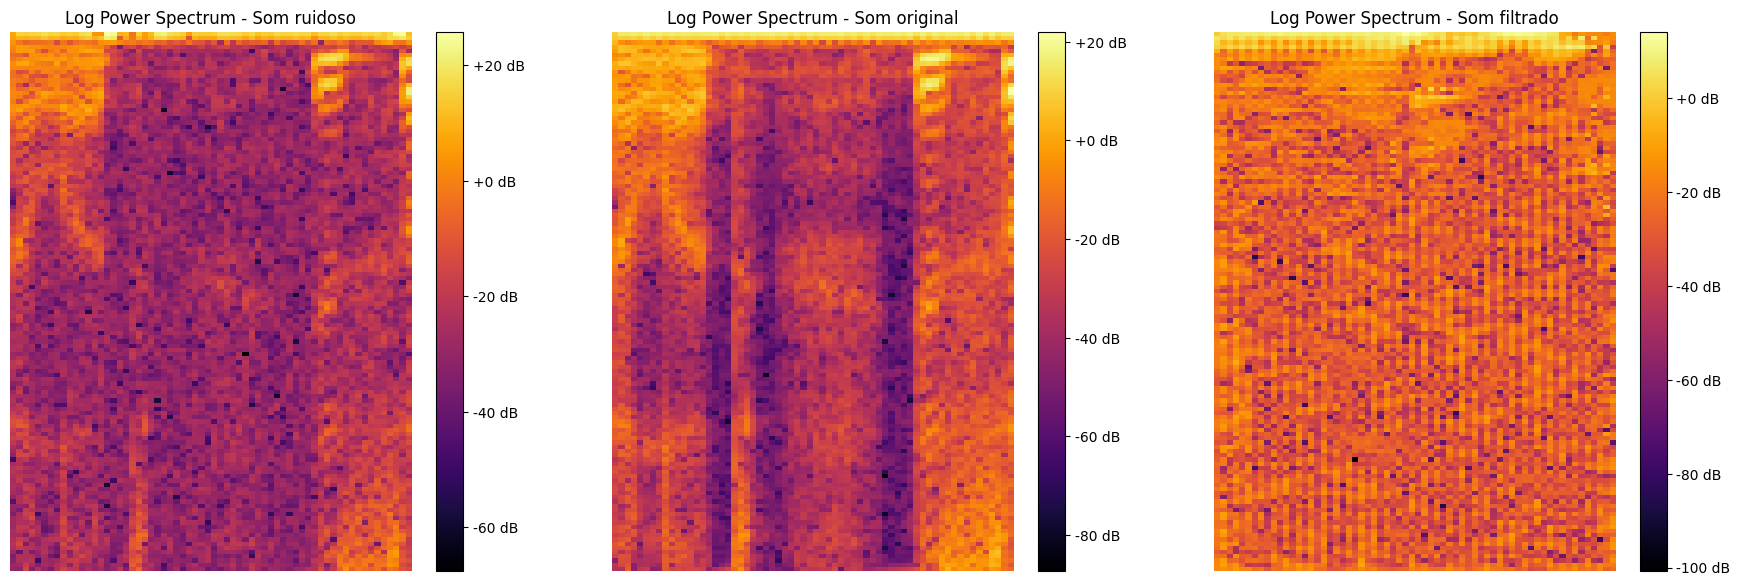

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0401 - val_loss: 0.0486 - lr: 3.4300e-05
Epoch 33/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0401

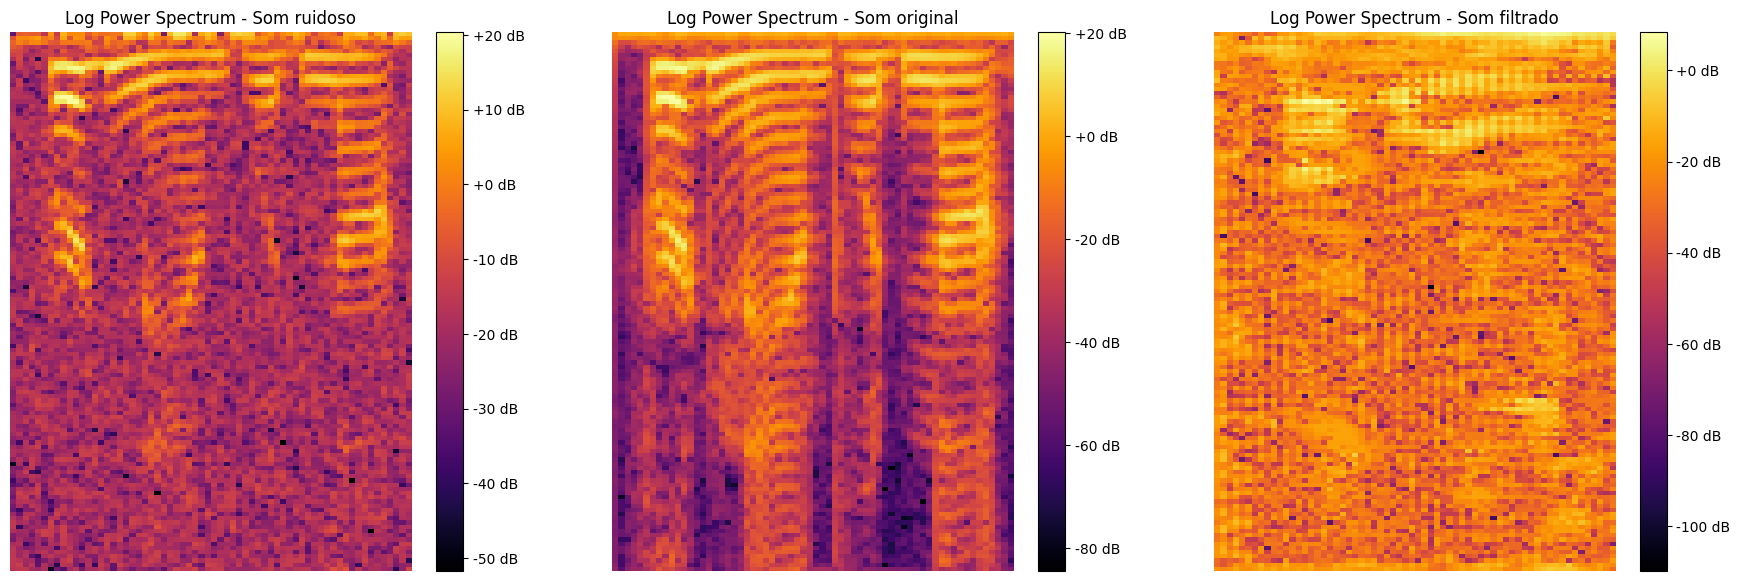

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0401 - val_loss: 0.0496 - lr: 3.4300e-05
Epoch 34/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0403

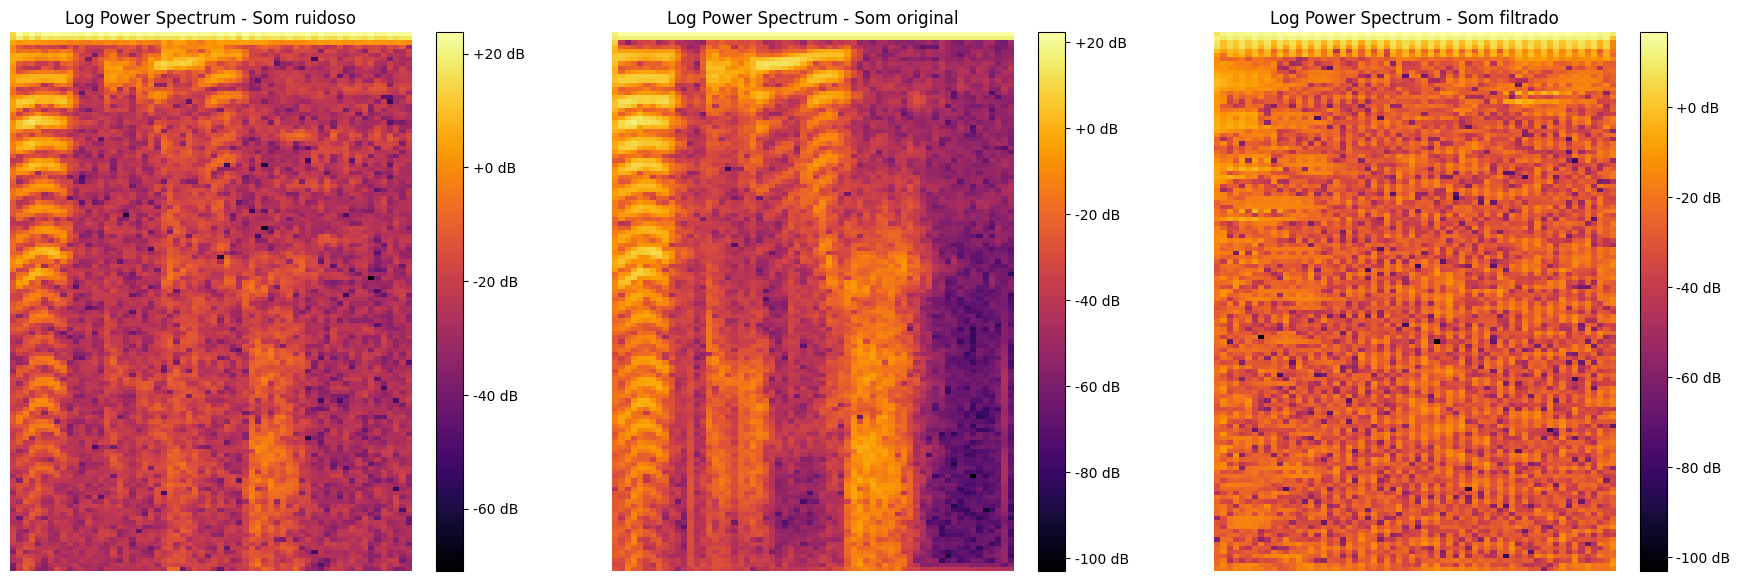

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0403 - val_loss: 0.0485 - lr: 3.4300e-05
Epoch 35/200
3506/3506 [==============================] - ETA: 0s - loss: 0.0400

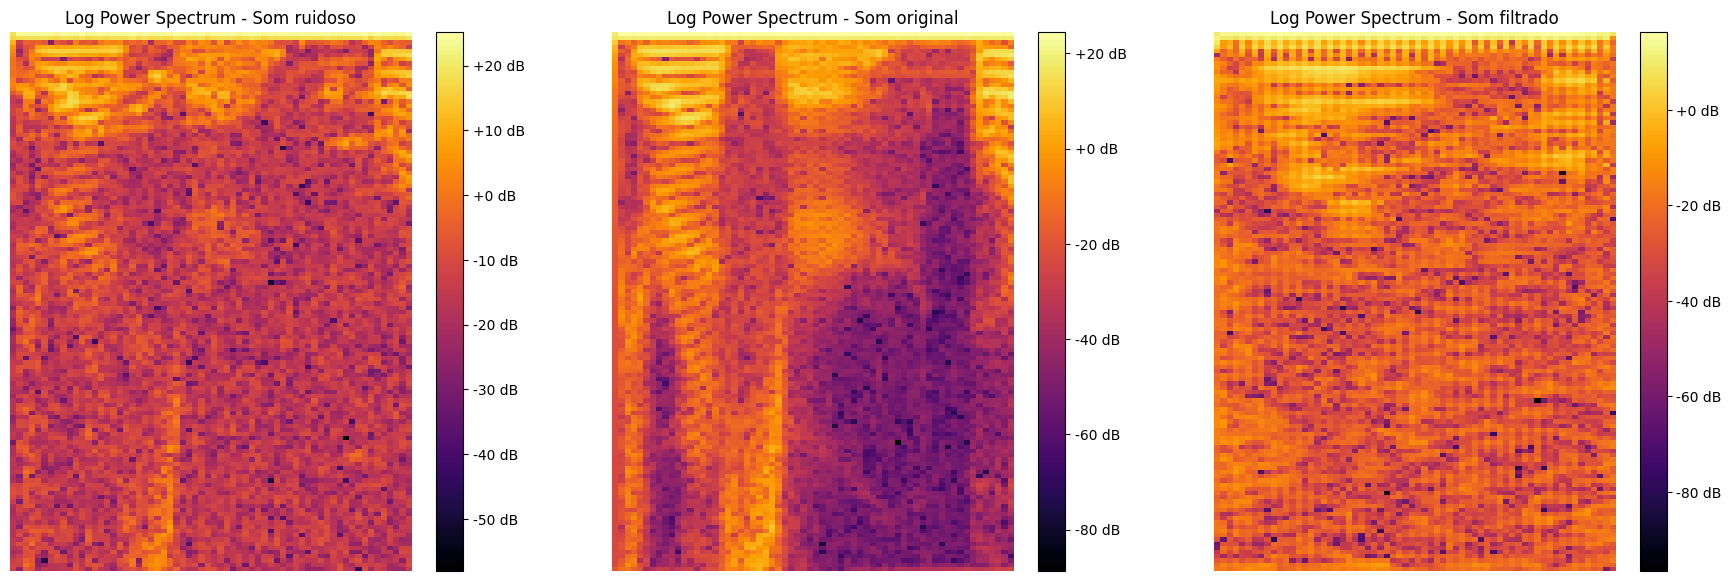

3506/3506 [==============================] - 1031s 294ms/step - loss: 0.0400 - val_loss: 0.0503 - lr: 3.4300e-05
Epoch 36/200
1299/3506 [==========>...................] - ETA: 10:53 - loss: 0.0404

KeyboardInterrupt: 

In [19]:
batch_size = 8
steps_per_epoch = len(sound_base_train.clean_sounds) // batch_size
epochs = 200

val_data = next(data_generator_val.generate_sample_completo(batch_size=4 * batch_size, include_clean=False, only_return_mudule=True))

model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size, include_clean=False, only_return_mudule=True),
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=val_data,
          callbacks=callbacks_lst
         )

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
validation_batch = next(data_generator_val.generate_sample_completo(batch_size=8))
x_test, y_test = validation_batch

x_test = x_test[0, ...]
y_test = y_test[0, ...]

x_test = x_test[np.newaxis, ...]
y_test = y_test[np.newaxis, ...]

In [ ]:
print(np.max(x_test[:, :, : , 0]))
print(np.min(x_test[:, :, : , 0]))
print(np.max(y_test[:, :, : , 0]))
print(np.min(y_test[:, :, : , 0]))

In [ ]:
x_test.shape

In [ ]:
F_f = model.predict(x_test[:, :, :, 0].reshape(-1, 128, 64, 1))

In [ ]:
print(np.max(F_f))
print(np.min(F_f))
print(F_f.shape)

In [ ]:
A = y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 0]
phi = (y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_f = F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 0]
# phi_f = (F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_n = x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 0]
phi_n = (x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

In [ ]:
print(np.max(A_f))
# print(np.max(phi_f))
print(np.min(A_f))
# print(np.min(phi_f))

In [ ]:
generate_images(model, x_test, y_test)

In [ ]:
s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f, phi_n)

In [ ]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [ ]:
Audio(data=s, rate=8000)

In [ ]:
Audio(data=s_n, rate=8000)

In [ ]:
Audio(data=s_f, rate=8000)